In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.table_dnn as table_dnn
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

classes = [letter_to_class[l] for l in letters]
branch_defs = [(('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'), 0.5235235235235235, 1), (('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5165165165165165, 0.5235235235235235), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5115115115115115, 0.5165165165165165), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4944944944944945, 0.5115115115115115), (('I', 'J'), 0.4794794794794795, 0.4944944944944945), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4724724724724725, 0.4944944944944945), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'M', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.45645645645645644, 0.4724724724724725), (('F', 'P', 'T', 'V', 'Y'), 0.4364364364364364, 0.4724724724724725), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.4174174174174174, 0.45645645645645644), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4134134134134134, 0.4174174174174174), (('B', 'D', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4094094094094094, 0.4134134134134134), (('F', 'T', 'V', 'Y'), 0.4024024024024024, 0.4364364364364364), (('B', 'D', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3863863863863864, 0.4094094094094094), (('B', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3813813813813814, 0.3863863863863864), (('B', 'G', 'H', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3733733733733734, 0.3813813813813814), (('F', 'T', 'Y'), 0.36036036036036034, 0.4024024024024024), (('C', 'E'), 0.3563563563563564, 0.4134134134134134), (('T', 'Y'), 0.3533533533533533, 0.36036036036036034), (('B', 'R', 'S', 'X', 'Z'), 0.35135135135135137, 0.3733733733733734), (('G', 'H', 'O', 'Q'), 0.34134134134134136, 0.3733733733733734), (('B', 'S', 'X', 'Z'), 0.32232232232232233, 0.35135135135135137), (('B', 'S', 'X'), 0.27627627627627627, 0.32232232232232233), (('G', 'H', 'O'), 0.26426426426426425, 0.34134134134134136), (('G', 'O'), 0.25725725725725723, 0.26426426426426425), (('S', 'X'), 0.15615615615615616, 0.27627627627627627), (('W',), 0, 0.5235235235235235), (('A',), 0, 0.5165165165165165), (('L',), 0, 0.5115115115115115), (('J',), 0, 0.4794794794794795), (('I',), 0, 0.4794794794794795), (('M',), 0, 0.45645645645645644), (('P',), 0, 0.4364364364364364), (('U',), 0, 0.4174174174174174), (('N',), 0, 0.4094094094094094), (('V',), 0, 0.4024024024024024), (('D',), 0, 0.3863863863863864), (('K',), 0, 0.3813813813813814), (('F',), 0, 0.36036036036036034), (('E',), 0, 0.3563563563563564), (('C',), 0, 0.3563563563563564), (('Y',), 0, 0.3533533533533533), (('T',), 0, 0.3533533533533533), (('R',), 0, 0.35135135135135137), (('Q',), 0, 0.34134134134134136), (('Z',), 0, 0.32232232232232233), (('B',), 0, 0.27627627627627627), (('H',), 0, 0.26426426426426425), (('G',), 0, 0.25725725725725723), (('O',), 0, 0.25725725725725723), (('S',), 0, 0.15615615615615616), (('X',), 0, 0.15615615615615616)]

# classes = [letter_to_class[l] for l in ("X", "O", "Q")]
# branch_defs = [
#     (("X", "O", "Q"), 0.5, 1),
#     (("X",), 0, 0.5),
#     (("O", "Q"), 0.4, 0.5),
#     (("O",), 0, 0.4),
#     (("Q",), 0, 0.4)
# ]

# classes = [letter_to_class[l] for l in ("A", "V", "Y")]
# branch_defs = [
#     (("A", "V", "Y"), 0.65, 1),
#     (("A",), 0, 0.65),
#     (("V", "Y"), 0.35, 0.65),
#     (("V",), 0, 0.35),
#     (("Y",), 0, 0.35)
# ]

# classes = [letter_to_class["O"]]
# branch_defs = [(("O",), 0, 1)]

# classes = [letter_to_class[l] for l in letters]
# branch_defs = [(tuple(letters), 0, 1)]

branch_defs = [
    (tuple(map(lambda l: letter_to_class[l], trip[0])), trip[1], trip[2])
    for trip in branch_defs
]

In [4]:
class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array([letter_to_class[l] for l in targets])
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [6]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 1, input_shape)

t_limit = 1
model = table_dnn.MultitaskTabularNet(
    len(branch_defs), input_shape[0], t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/letters_continuous_allletters"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

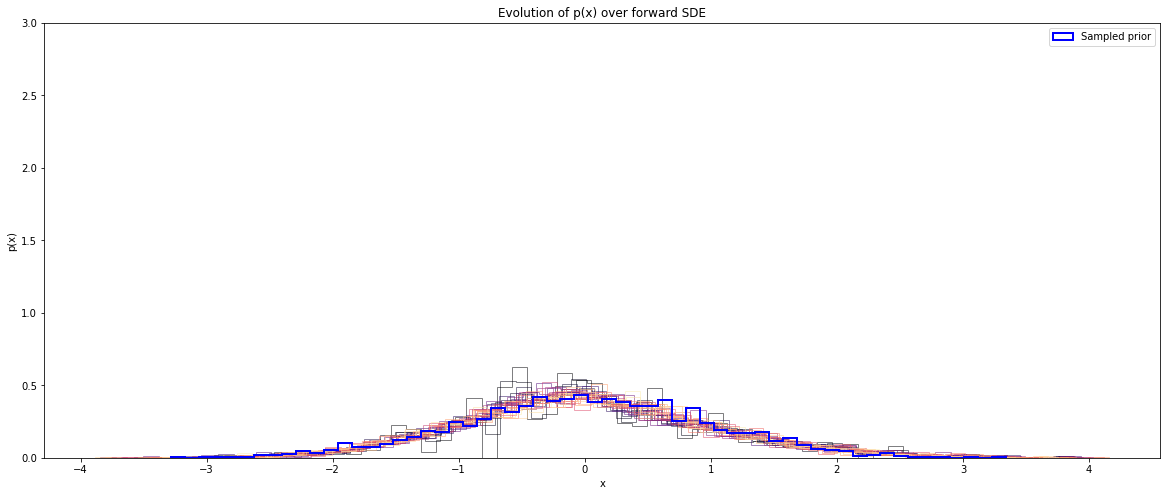

In [7]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [8]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 500,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "4"
Loss: 11.68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 1 average Loss: 13.26


Loss: 12.05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.54it/s]


Epoch 2 average Loss: 11.85


Loss: 10.20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 3 average Loss: 11.25


Loss: 11.24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 4 average Loss: 10.92


Loss: 10.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 5 average Loss: 10.58


Loss: 8.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 6 average Loss: 10.45


Loss: 10.40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.41it/s]


Epoch 7 average Loss: 10.24


Loss: 9.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 8 average Loss: 10.18


Loss: 10.07: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 9 average Loss: 10.10


Loss: 8.75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 10 average Loss: 9.97


Loss: 9.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 11 average Loss: 9.90


Loss: 9.26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.64it/s]


Epoch 12 average Loss: 9.83


Loss: 10.20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.56it/s]


Epoch 13 average Loss: 9.83


Loss: 9.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 14 average Loss: 9.75


Loss: 9.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 15 average Loss: 9.66


Loss: 10.41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.49it/s]


Epoch 16 average Loss: 9.64


Loss: 9.72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 17 average Loss: 9.62


Loss: 9.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 18 average Loss: 9.59


Loss: 8.41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 19 average Loss: 9.54


Loss: 9.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 20 average Loss: 9.54


Loss: 10.05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.48it/s]


Epoch 21 average Loss: 9.50


Loss: 10.45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 22 average Loss: 9.46


Loss: 9.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.59it/s]


Epoch 23 average Loss: 9.39


Loss: 9.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 24 average Loss: 9.36


Loss: 8.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 25 average Loss: 9.37


Loss: 9.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 26 average Loss: 9.33


Loss: 8.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 27 average Loss: 9.27


Loss: 8.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 28 average Loss: 9.28


Loss: 9.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 29 average Loss: 9.28


Loss: 9.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.61it/s]


Epoch 30 average Loss: 9.25


Loss: 7.83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.47it/s]


Epoch 31 average Loss: 9.21


Loss: 8.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 32 average Loss: 9.20


Loss: 9.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 33 average Loss: 9.19


Loss: 9.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 34 average Loss: 9.10


Loss: 8.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 35 average Loss: 9.14


Loss: 9.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 36 average Loss: 9.10


Loss: 8.76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 37 average Loss: 9.13


Loss: 8.71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.43it/s]


Epoch 38 average Loss: 9.06


Loss: 9.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 39 average Loss: 9.03


Loss: 9.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 40 average Loss: 9.05


Loss: 8.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 41 average Loss: 9.05


Loss: 8.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.16it/s]


Epoch 42 average Loss: 9.05


Loss: 8.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 43 average Loss: 9.01


Loss: 9.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.42it/s]


Epoch 44 average Loss: 8.99


Loss: 8.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 45 average Loss: 8.97


Loss: 9.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.15it/s]


Epoch 46 average Loss: 8.94


Loss: 9.27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.08it/s]


Epoch 47 average Loss: 8.95


Loss: 9.04: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 48 average Loss: 8.90


Loss: 8.42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 49 average Loss: 8.91


Loss: 9.06: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 50 average Loss: 8.90


Loss: 8.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.15it/s]


Epoch 51 average Loss: 8.89


Loss: 8.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 52 average Loss: 8.91


Loss: 9.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.14it/s]


Epoch 53 average Loss: 8.90


Loss: 9.42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 54 average Loss: 8.80


Loss: 8.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 55 average Loss: 8.81


Loss: 8.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 56 average Loss: 8.82


Loss: 7.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 57 average Loss: 8.82


Loss: 10.16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 58 average Loss: 8.79


Loss: 8.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 59 average Loss: 8.76


Loss: 9.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 60 average Loss: 8.78


Loss: 8.58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 61 average Loss: 8.76


Loss: 8.72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 62 average Loss: 8.70


Loss: 10.04: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 63 average Loss: 8.76


Loss: 8.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 64 average Loss: 8.78


Loss: 8.04: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 65 average Loss: 8.72


Loss: 9.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 66 average Loss: 8.75


Loss: 7.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 67 average Loss: 8.75


Loss: 8.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 68 average Loss: 8.72


Loss: 7.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 69 average Loss: 8.71


Loss: 8.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 70 average Loss: 8.70


Loss: 9.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 71 average Loss: 8.66


Loss: 8.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 72 average Loss: 8.68


Loss: 9.50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.42it/s]


Epoch 73 average Loss: 8.66


Loss: 7.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.43it/s]


Epoch 74 average Loss: 8.66


Loss: 9.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 75 average Loss: 8.63


Loss: 7.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 76 average Loss: 8.63


Loss: 8.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.42it/s]


Epoch 77 average Loss: 8.63


Loss: 9.48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.58it/s]


Epoch 78 average Loss: 8.62


Loss: 9.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 79 average Loss: 8.66


Loss: 8.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.55it/s]


Epoch 80 average Loss: 8.62


Loss: 8.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 81 average Loss: 8.58


Loss: 7.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 82 average Loss: 8.62


Loss: 8.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.43it/s]


Epoch 83 average Loss: 8.59


Loss: 9.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.41it/s]


Epoch 84 average Loss: 8.59


Loss: 8.27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.41it/s]


Epoch 85 average Loss: 8.59


Loss: 8.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 86 average Loss: 8.56


Loss: 9.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch 87 average Loss: 8.58


Loss: 9.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 88 average Loss: 8.55


Loss: 9.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.45it/s]


Epoch 89 average Loss: 8.58


Loss: 8.99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 90 average Loss: 8.56


Loss: 8.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 91 average Loss: 8.52


Loss: 8.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 92 average Loss: 8.54


Loss: 8.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.62it/s]


Epoch 93 average Loss: 8.52


Loss: 8.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 94 average Loss: 8.53


Loss: 7.68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.51it/s]


Epoch 95 average Loss: 8.54


Loss: 8.25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.58it/s]


Epoch 96 average Loss: 8.49


Loss: 9.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 97 average Loss: 8.47


Loss: 7.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 98 average Loss: 8.48


Loss: 9.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 99 average Loss: 8.51


Loss: 8.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 100 average Loss: 8.50


Loss: 9.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 101 average Loss: 8.54


Loss: 8.65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 102 average Loss: 8.42


Loss: 8.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 103 average Loss: 8.48


Loss: 6.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 104 average Loss: 8.44


Loss: 8.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.59it/s]


Epoch 105 average Loss: 8.48


Loss: 8.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 106 average Loss: 8.46


Loss: 8.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 107 average Loss: 8.47


Loss: 9.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.46it/s]


Epoch 108 average Loss: 8.46


Loss: 7.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 109 average Loss: 8.45


Loss: 8.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.56it/s]


Epoch 110 average Loss: 8.45


Loss: 6.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 111 average Loss: 8.44


Loss: 8.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch 112 average Loss: 8.43


Loss: 7.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 113 average Loss: 8.38


Loss: 8.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 114 average Loss: 8.42


Loss: 9.63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 115 average Loss: 8.39


Loss: 8.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 116 average Loss: 8.42


Loss: 8.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 117 average Loss: 8.44


Loss: 8.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 118 average Loss: 8.39


Loss: 8.49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.57it/s]


Epoch 119 average Loss: 8.39


Loss: 8.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 120 average Loss: 8.41


Loss: 8.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.46it/s]


Epoch 121 average Loss: 8.37


Loss: 7.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.48it/s]


Epoch 122 average Loss: 8.42


Loss: 9.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.43it/s]


Epoch 123 average Loss: 8.42


Loss: 8.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 124 average Loss: 8.32


Loss: 7.71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.48it/s]


Epoch 125 average Loss: 8.36


Loss: 8.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.41it/s]


Epoch 126 average Loss: 8.36


Loss: 8.49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 127 average Loss: 8.32


Loss: 8.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 128 average Loss: 8.38


Loss: 7.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.45it/s]


Epoch 129 average Loss: 8.31


Loss: 8.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 130 average Loss: 8.35


Loss: 8.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 131 average Loss: 8.36


Loss: 8.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 132 average Loss: 8.34


Loss: 9.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.55it/s]


Epoch 133 average Loss: 8.30


Loss: 8.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 134 average Loss: 8.29


Loss: 8.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 135 average Loss: 8.37


Loss: 9.72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 136 average Loss: 8.33


Loss: 7.67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.43it/s]


Epoch 137 average Loss: 8.28


Loss: 8.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 138 average Loss: 8.28


Loss: 8.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 139 average Loss: 8.32


Loss: 7.60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 140 average Loss: 8.33


Loss: 7.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 141 average Loss: 8.29


Loss: 8.24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 142 average Loss: 8.26


Loss: 7.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 143 average Loss: 8.31


Loss: 7.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.44it/s]


Epoch 144 average Loss: 8.28


Loss: 9.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 145 average Loss: 8.29


Loss: 8.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 146 average Loss: 8.28


Loss: 8.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 147 average Loss: 8.31


Loss: 8.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 148 average Loss: 8.30


Loss: 7.99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 149 average Loss: 8.25


Loss: 8.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 150 average Loss: 8.27


Loss: 8.75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 151 average Loss: 8.24


Loss: 8.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.44it/s]


Epoch 152 average Loss: 8.26


Loss: 7.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 153 average Loss: 8.23


Loss: 7.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 154 average Loss: 8.24


Loss: 7.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 155 average Loss: 8.25


Loss: 7.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 156 average Loss: 8.21


Loss: 8.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 157 average Loss: 8.28


Loss: 7.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 158 average Loss: 8.22


Loss: 8.30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.28it/s]


Epoch 159 average Loss: 8.17


Loss: 7.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 160 average Loss: 8.20


Loss: 9.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 161 average Loss: 8.18


Loss: 8.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 162 average Loss: 8.21


Loss: 9.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 163 average Loss: 8.21


Loss: 8.04: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 164 average Loss: 8.20


Loss: 7.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 165 average Loss: 8.21


Loss: 9.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 166 average Loss: 8.23


Loss: 9.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.13it/s]


Epoch 167 average Loss: 8.22


Loss: 7.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 168 average Loss: 8.21


Loss: 8.39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.42it/s]


Epoch 169 average Loss: 8.19


Loss: 7.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.43it/s]


Epoch 170 average Loss: 8.16


Loss: 8.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 171 average Loss: 8.19


Loss: 7.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.41it/s]


Epoch 172 average Loss: 8.20


Loss: 7.67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.42it/s]


Epoch 173 average Loss: 8.14


Loss: 7.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 174 average Loss: 8.17


Loss: 8.77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 175 average Loss: 8.14


Loss: 7.26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.16it/s]


Epoch 176 average Loss: 8.15


Loss: 8.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 177 average Loss: 8.17


Loss: 8.54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 178 average Loss: 8.13


Loss: 7.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.14it/s]


Epoch 179 average Loss: 8.21


Loss: 7.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 180 average Loss: 8.09


Loss: 7.71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.16it/s]


Epoch 181 average Loss: 8.16


Loss: 9.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.11it/s]


Epoch 182 average Loss: 8.20


Loss: 6.80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.11it/s]


Epoch 183 average Loss: 8.14


Loss: 7.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.14it/s]


Epoch 184 average Loss: 8.18


Loss: 7.48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.07it/s]


Epoch 185 average Loss: 8.15


Loss: 7.42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.13it/s]


Epoch 186 average Loss: 8.13


Loss: 8.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.14it/s]


Epoch 187 average Loss: 8.11


Loss: 8.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 188 average Loss: 8.16


Loss: 7.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.09it/s]


Epoch 189 average Loss: 8.12


Loss: 9.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.16it/s]


Epoch 190 average Loss: 8.15


Loss: 7.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.15it/s]


Epoch 191 average Loss: 8.09


Loss: 7.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 192 average Loss: 8.13


Loss: 7.68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.52it/s]


Epoch 193 average Loss: 8.07


Loss: 8.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 194 average Loss: 8.17


Loss: 8.49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 195 average Loss: 8.11


Loss: 7.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 196 average Loss: 8.13


Loss: 7.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 197 average Loss: 8.13


Loss: 7.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 198 average Loss: 8.10


Loss: 9.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 199 average Loss: 8.11


Loss: 7.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 200 average Loss: 8.11


Loss: 8.54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 201 average Loss: 8.11


Loss: 7.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 202 average Loss: 8.11


Loss: 8.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 203 average Loss: 8.12


Loss: 8.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.20it/s]


Epoch 204 average Loss: 8.12


Loss: 7.20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 205 average Loss: 8.06


Loss: 7.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 206 average Loss: 8.09


Loss: 7.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 207 average Loss: 8.07


Loss: 8.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 208 average Loss: 8.06


Loss: 6.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 209 average Loss: 8.09


Loss: 7.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.28it/s]


Epoch 210 average Loss: 8.09


Loss: 8.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.47it/s]


Epoch 211 average Loss: 8.10


Loss: 7.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 212 average Loss: 8.08


Loss: 8.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 213 average Loss: 8.08


Loss: 8.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.15it/s]


Epoch 214 average Loss: 8.06


Loss: 7.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 215 average Loss: 8.03


Loss: 7.57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 216 average Loss: 8.06


Loss: 7.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 217 average Loss: 8.05


Loss: 8.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 218 average Loss: 8.07


Loss: 7.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 219 average Loss: 8.06


Loss: 7.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.43it/s]


Epoch 220 average Loss: 8.04


Loss: 8.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 221 average Loss: 8.05


Loss: 8.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 222 average Loss: 8.01


Loss: 8.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 223 average Loss: 8.05


Loss: 7.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 224 average Loss: 8.04


Loss: 7.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 225 average Loss: 8.03


Loss: 7.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 226 average Loss: 8.05


Loss: 8.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 227 average Loss: 8.03


Loss: 7.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 228 average Loss: 8.06


Loss: 7.71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 229 average Loss: 8.04


Loss: 7.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.54it/s]


Epoch 230 average Loss: 7.98


Loss: 9.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 231 average Loss: 8.06


Loss: 6.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 232 average Loss: 8.02


Loss: 7.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.46it/s]


Epoch 233 average Loss: 8.05


Loss: 8.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 234 average Loss: 8.03


Loss: 7.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 235 average Loss: 7.97


Loss: 6.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 236 average Loss: 8.00


Loss: 7.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 237 average Loss: 8.01


Loss: 7.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 238 average Loss: 8.03


Loss: 8.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.20it/s]


Epoch 239 average Loss: 8.05


Loss: 6.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 240 average Loss: 8.02


Loss: 7.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.14it/s]


Epoch 241 average Loss: 7.98


Loss: 7.67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 242 average Loss: 7.96


Loss: 8.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 243 average Loss: 7.98


Loss: 9.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 244 average Loss: 7.97


Loss: 8.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 245 average Loss: 8.01


Loss: 8.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 246 average Loss: 8.04


Loss: 8.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 247 average Loss: 8.00


Loss: 8.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 248 average Loss: 8.00


Loss: 7.90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 249 average Loss: 7.97


Loss: 9.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 250 average Loss: 7.98


Loss: 7.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 251 average Loss: 7.99


Loss: 8.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 252 average Loss: 7.99


Loss: 7.05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.44it/s]


Epoch 253 average Loss: 7.96


Loss: 7.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 254 average Loss: 7.95


Loss: 8.27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 255 average Loss: 7.96


Loss: 8.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 256 average Loss: 7.95


Loss: 7.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 257 average Loss: 7.95


Loss: 8.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 258 average Loss: 7.98


Loss: 8.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 259 average Loss: 7.95


Loss: 6.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 260 average Loss: 7.94


Loss: 8.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 261 average Loss: 7.94


Loss: 7.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 262 average Loss: 7.96


Loss: 8.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 263 average Loss: 7.97


Loss: 8.58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 264 average Loss: 7.97


Loss: 7.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 265 average Loss: 7.94


Loss: 8.67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 266 average Loss: 7.92


Loss: 7.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 267 average Loss: 7.95


Loss: 7.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 268 average Loss: 7.96


Loss: 7.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.45it/s]


Epoch 269 average Loss: 7.94


Loss: 9.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 270 average Loss: 7.93


Loss: 7.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 271 average Loss: 7.96


Loss: 7.05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 272 average Loss: 7.94


Loss: 6.75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 273 average Loss: 7.96


Loss: 7.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 274 average Loss: 7.92


Loss: 7.65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 275 average Loss: 7.90


Loss: 7.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.48it/s]


Epoch 276 average Loss: 7.92


Loss: 7.75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.42it/s]


Epoch 277 average Loss: 7.93


Loss: 8.62: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.20it/s]


Epoch 278 average Loss: 7.90


Loss: 7.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 279 average Loss: 7.93


Loss: 6.65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 280 average Loss: 7.93


Loss: 7.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 281 average Loss: 7.93


Loss: 7.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 282 average Loss: 7.92


Loss: 8.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 283 average Loss: 7.89


Loss: 7.39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.28it/s]


Epoch 284 average Loss: 7.91


Loss: 8.42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.28it/s]


Epoch 285 average Loss: 7.97


Loss: 8.76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 286 average Loss: 7.89


Loss: 7.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 287 average Loss: 7.87


Loss: 7.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 288 average Loss: 7.92


Loss: 8.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 289 average Loss: 7.88


Loss: 7.55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 290 average Loss: 7.88


Loss: 9.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 291 average Loss: 7.96


Loss: 7.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 292 average Loss: 7.91


Loss: 8.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 293 average Loss: 7.91


Loss: 7.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.44it/s]


Epoch 294 average Loss: 7.85


Loss: 8.67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 295 average Loss: 7.89


Loss: 8.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 296 average Loss: 7.87


Loss: 7.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 297 average Loss: 7.89


Loss: 8.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 298 average Loss: 7.86


Loss: 7.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 299 average Loss: 7.88


Loss: 7.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 300 average Loss: 7.89


Loss: 7.20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 301 average Loss: 7.87


Loss: 8.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 302 average Loss: 7.85


Loss: 9.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 303 average Loss: 7.95


Loss: 8.06: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 304 average Loss: 7.91


Loss: 7.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.52it/s]


Epoch 305 average Loss: 7.85


Loss: 8.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 306 average Loss: 7.85


Loss: 7.72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 307 average Loss: 7.85


Loss: 9.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 308 average Loss: 7.87


Loss: 7.99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 309 average Loss: 7.88


Loss: 8.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 310 average Loss: 7.87


Loss: 7.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 311 average Loss: 7.87


Loss: 8.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.14it/s]


Epoch 312 average Loss: 7.87


Loss: 7.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.08it/s]


Epoch 313 average Loss: 7.90


Loss: 6.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.12it/s]


Epoch 314 average Loss: 7.83


Loss: 7.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.09it/s]


Epoch 315 average Loss: 7.79


Loss: 7.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.15it/s]


Epoch 316 average Loss: 7.81


Loss: 7.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.11it/s]


Epoch 317 average Loss: 7.86


Loss: 7.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.11it/s]


Epoch 318 average Loss: 7.85


Loss: 7.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.05it/s]


Epoch 319 average Loss: 7.87


Loss: 7.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.08it/s]


Epoch 320 average Loss: 7.82


Loss: 7.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.00it/s]


Epoch 321 average Loss: 7.87


Loss: 7.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.06it/s]


Epoch 322 average Loss: 7.79


Loss: 8.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.04it/s]


Epoch 323 average Loss: 7.88


Loss: 8.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.04it/s]


Epoch 324 average Loss: 7.80


Loss: 8.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.14it/s]


Epoch 325 average Loss: 7.84


Loss: 8.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.10it/s]


Epoch 326 average Loss: 7.79


Loss: 7.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.12it/s]


Epoch 327 average Loss: 7.83


Loss: 9.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.16it/s]


Epoch 328 average Loss: 7.81


Loss: 7.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 329 average Loss: 7.81


Loss: 7.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 330 average Loss: 7.86


Loss: 8.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.46it/s]


Epoch 331 average Loss: 7.80


Loss: 7.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 332 average Loss: 7.82


Loss: 8.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 333 average Loss: 7.82


Loss: 8.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.20it/s]


Epoch 334 average Loss: 7.83


Loss: 7.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 335 average Loss: 7.75


Loss: 8.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 336 average Loss: 7.82


Loss: 7.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 337 average Loss: 7.84


Loss: 6.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 338 average Loss: 7.80


Loss: 8.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 339 average Loss: 7.77


Loss: 7.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 340 average Loss: 7.80


Loss: 6.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch 341 average Loss: 7.80


Loss: 7.80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 342 average Loss: 7.76


Loss: 6.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 343 average Loss: 7.77


Loss: 8.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.46it/s]


Epoch 344 average Loss: 7.85


Loss: 8.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.54it/s]


Epoch 345 average Loss: 7.82


Loss: 7.55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 346 average Loss: 7.81


Loss: 6.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 347 average Loss: 7.79


Loss: 6.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 348 average Loss: 7.81


Loss: 7.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.09it/s]


Epoch 349 average Loss: 7.80


Loss: 8.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.13it/s]


Epoch 350 average Loss: 7.83


Loss: 7.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.11it/s]


Epoch 351 average Loss: 7.78


Loss: 8.37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 352 average Loss: 7.74


Loss: 7.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.11it/s]


Epoch 353 average Loss: 7.80


Loss: 6.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.10it/s]


Epoch 354 average Loss: 7.75


Loss: 9.04: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.03it/s]


Epoch 355 average Loss: 7.85


Loss: 7.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.12it/s]


Epoch 356 average Loss: 7.82


Loss: 7.68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.04it/s]


Epoch 357 average Loss: 7.76


Loss: 8.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.95it/s]


Epoch 358 average Loss: 7.84


Loss: 7.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.08it/s]


Epoch 359 average Loss: 7.80


Loss: 8.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.10it/s]


Epoch 360 average Loss: 7.80


Loss: 7.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.08it/s]


Epoch 361 average Loss: 7.78


Loss: 7.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.10it/s]


Epoch 362 average Loss: 7.78


Loss: 8.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.06it/s]


Epoch 363 average Loss: 7.74


Loss: 8.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.12it/s]


Epoch 364 average Loss: 7.81


Loss: 7.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.08it/s]


Epoch 365 average Loss: 7.78


Loss: 8.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.56it/s]


Epoch 366 average Loss: 7.74


Loss: 8.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 367 average Loss: 7.78


Loss: 7.90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.46it/s]


Epoch 368 average Loss: 7.75


Loss: 8.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 369 average Loss: 7.71


Loss: 8.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 370 average Loss: 7.83


Loss: 7.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 371 average Loss: 7.76


Loss: 8.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 372 average Loss: 7.77


Loss: 6.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 373 average Loss: 7.78


Loss: 8.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 374 average Loss: 7.72


Loss: 7.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 375 average Loss: 7.75


Loss: 7.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 376 average Loss: 7.76


Loss: 8.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 377 average Loss: 7.76


Loss: 7.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 378 average Loss: 7.70


Loss: 7.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 379 average Loss: 7.75


Loss: 8.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 380 average Loss: 7.74


Loss: 8.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.55it/s]


Epoch 381 average Loss: 7.70


Loss: 7.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.46it/s]


Epoch 382 average Loss: 7.72


Loss: 7.26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 383 average Loss: 7.72


Loss: 8.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 384 average Loss: 7.73


Loss: 8.76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 385 average Loss: 7.74


Loss: 8.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.14it/s]


Epoch 386 average Loss: 7.78


Loss: 8.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 387 average Loss: 7.74


Loss: 8.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 388 average Loss: 7.75


Loss: 7.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 389 average Loss: 7.72


Loss: 7.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 390 average Loss: 7.74


Loss: 7.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 391 average Loss: 7.75


Loss: 7.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 392 average Loss: 7.69


Loss: 7.60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 393 average Loss: 7.72


Loss: 7.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 394 average Loss: 7.74


Loss: 6.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 395 average Loss: 7.74


Loss: 6.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 396 average Loss: 7.72


Loss: 7.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 397 average Loss: 7.69


Loss: 8.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 398 average Loss: 7.76


Loss: 6.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 399 average Loss: 7.72


Loss: 8.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 400 average Loss: 7.72


Loss: 7.75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.28it/s]


Epoch 401 average Loss: 7.68


Loss: 7.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.15it/s]


Epoch 402 average Loss: 7.75


Loss: 8.72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 403 average Loss: 7.71


Loss: 7.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.28it/s]


Epoch 404 average Loss: 7.71


Loss: 8.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 405 average Loss: 7.71


Loss: 7.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 406 average Loss: 7.72


Loss: 7.90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 407 average Loss: 7.70


Loss: 7.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 408 average Loss: 7.76


Loss: 9.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 409 average Loss: 7.70


Loss: 7.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 410 average Loss: 7.72


Loss: 6.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 411 average Loss: 7.70


Loss: 7.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 412 average Loss: 7.71


Loss: 8.39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 413 average Loss: 7.71


Loss: 8.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.20it/s]


Epoch 414 average Loss: 7.70


Loss: 8.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 415 average Loss: 7.72


Loss: 7.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 416 average Loss: 7.70


Loss: 7.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 417 average Loss: 7.70


Loss: 6.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 418 average Loss: 7.67


Loss: 7.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 419 average Loss: 7.67


Loss: 8.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 420 average Loss: 7.67


Loss: 7.50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 421 average Loss: 7.72


Loss: 7.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 422 average Loss: 7.71


Loss: 8.27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 423 average Loss: 7.67


Loss: 6.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 424 average Loss: 7.71


Loss: 7.58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.24it/s]


Epoch 425 average Loss: 7.66


Loss: 8.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.47it/s]


Epoch 426 average Loss: 7.69


Loss: 7.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.13it/s]


Epoch 427 average Loss: 7.71


Loss: 6.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.46it/s]


Epoch 428 average Loss: 7.68


Loss: 7.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 429 average Loss: 7.69


Loss: 7.67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 430 average Loss: 7.72


Loss: 7.42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.23it/s]


Epoch 431 average Loss: 7.71


Loss: 7.27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 432 average Loss: 7.69


Loss: 7.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 433 average Loss: 7.68


Loss: 7.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 434 average Loss: 7.65


Loss: 7.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 435 average Loss: 7.69


Loss: 7.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 436 average Loss: 7.70


Loss: 7.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.43it/s]


Epoch 437 average Loss: 7.62


Loss: 7.86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.53it/s]


Epoch 438 average Loss: 7.68


Loss: 7.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.47it/s]


Epoch 439 average Loss: 7.66


Loss: 6.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 440 average Loss: 7.60


Loss: 9.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 441 average Loss: 7.69


Loss: 7.57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 442 average Loss: 7.66


Loss: 7.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 443 average Loss: 7.67


Loss: 7.60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 444 average Loss: 7.67


Loss: 7.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 445 average Loss: 7.66


Loss: 7.55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 446 average Loss: 7.65


Loss: 8.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 447 average Loss: 7.67


Loss: 7.30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 448 average Loss: 7.70


Loss: 7.90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 449 average Loss: 7.71


Loss: 7.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.45it/s]


Epoch 450 average Loss: 7.66


Loss: 7.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.13it/s]


Epoch 451 average Loss: 7.73


Loss: 8.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 452 average Loss: 7.66


Loss: 6.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 453 average Loss: 7.64


Loss: 7.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 454 average Loss: 7.65


Loss: 7.24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 455 average Loss: 7.70


Loss: 8.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.16it/s]


Epoch 456 average Loss: 7.69


Loss: 7.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 457 average Loss: 7.65


Loss: 7.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.13it/s]


Epoch 458 average Loss: 7.67


Loss: 8.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 459 average Loss: 7.68


Loss: 6.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.15it/s]


Epoch 460 average Loss: 7.67


Loss: 6.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.20it/s]


Epoch 461 average Loss: 7.66


Loss: 7.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 462 average Loss: 7.63


Loss: 8.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.22it/s]


Epoch 463 average Loss: 7.63


Loss: 6.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.16it/s]


Epoch 464 average Loss: 7.65


Loss: 7.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 465 average Loss: 7.62


Loss: 8.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 466 average Loss: 7.64


Loss: 7.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 467 average Loss: 7.63


Loss: 6.49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.34it/s]


Epoch 468 average Loss: 7.59


Loss: 6.71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 469 average Loss: 7.62


Loss: 7.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch 470 average Loss: 7.61


Loss: 7.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 471 average Loss: 7.62


Loss: 8.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 472 average Loss: 7.60


Loss: 6.41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 473 average Loss: 7.63


Loss: 7.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 474 average Loss: 7.59


Loss: 8.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch 475 average Loss: 7.59


Loss: 6.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.26it/s]


Epoch 476 average Loss: 7.63


Loss: 7.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 477 average Loss: 7.64


Loss: 8.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 478 average Loss: 7.62


Loss: 6.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 479 average Loss: 7.59


Loss: 8.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.51it/s]


Epoch 480 average Loss: 7.64


Loss: 8.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.43it/s]


Epoch 481 average Loss: 7.66


Loss: 7.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 482 average Loss: 7.63


Loss: 7.77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.41it/s]


Epoch 483 average Loss: 7.62


Loss: 7.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.48it/s]


Epoch 484 average Loss: 7.64


Loss: 7.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.46it/s]


Epoch 485 average Loss: 7.61


Loss: 8.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.44it/s]


Epoch 486 average Loss: 7.60


Loss: 7.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 487 average Loss: 7.65


Loss: 7.49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 488 average Loss: 7.63


Loss: 7.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.47it/s]


Epoch 489 average Loss: 7.63


Loss: 8.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 490 average Loss: 7.61


Loss: 8.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.49it/s]


Epoch 491 average Loss: 7.63


Loss: 6.80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 492 average Loss: 7.67


Loss: 6.25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 493 average Loss: 7.59


Loss: 7.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.27it/s]


Epoch 494 average Loss: 7.61


Loss: 8.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.16it/s]


Epoch 495 average Loss: 7.61


Loss: 7.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.32it/s]


Epoch 496 average Loss: 7.59


Loss: 8.24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.33it/s]


Epoch 497 average Loss: 7.60


Loss: 7.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 498 average Loss: 7.60


Loss: 6.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.15it/s]


Epoch 499 average Loss: 7.58


Loss: 6.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.19it/s]
INFO - train - Completed after 3:28:24


Epoch 500 average Loss: 7.58


### Show generated distributions

In [9]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit
    ).cpu().numpy()
    samples[class_to_sample] = sample

Class A


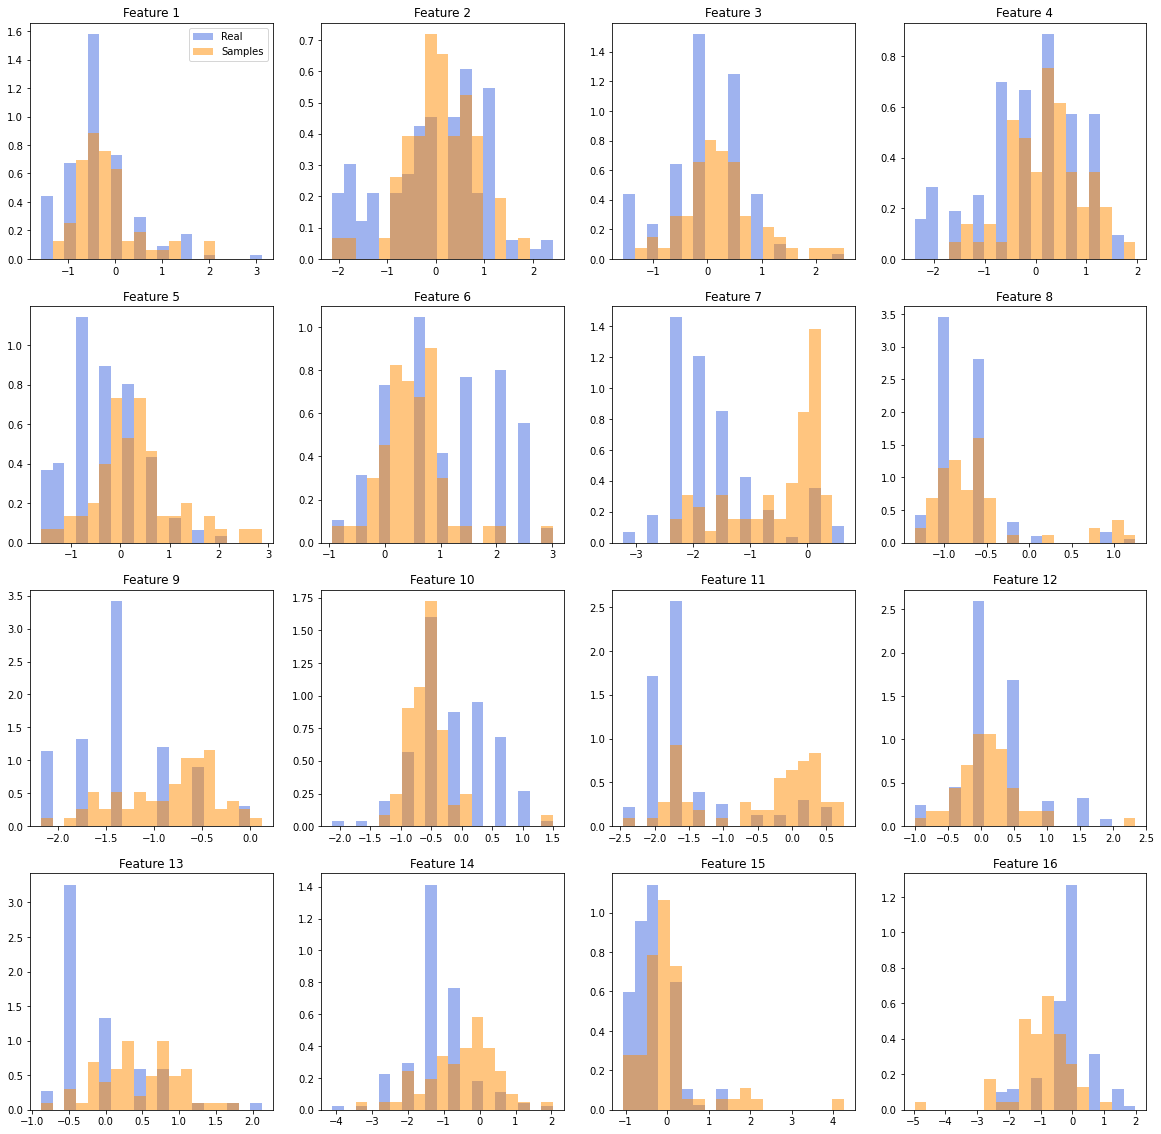

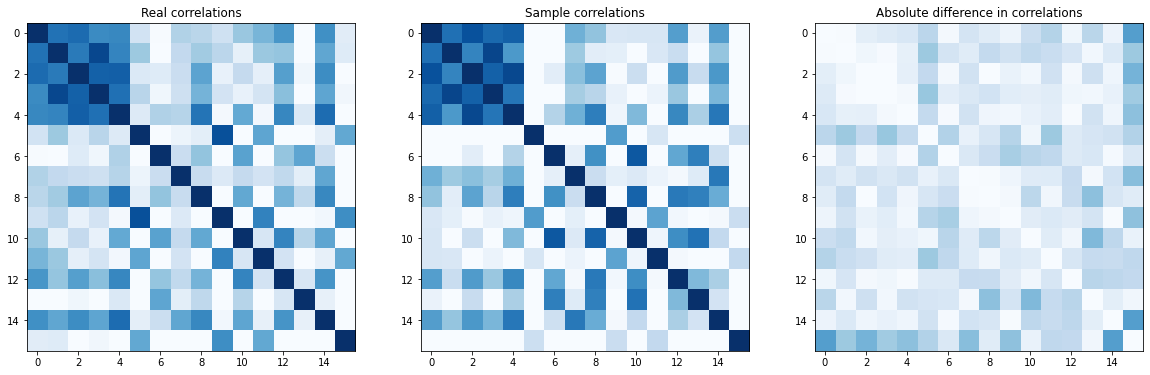

Class B


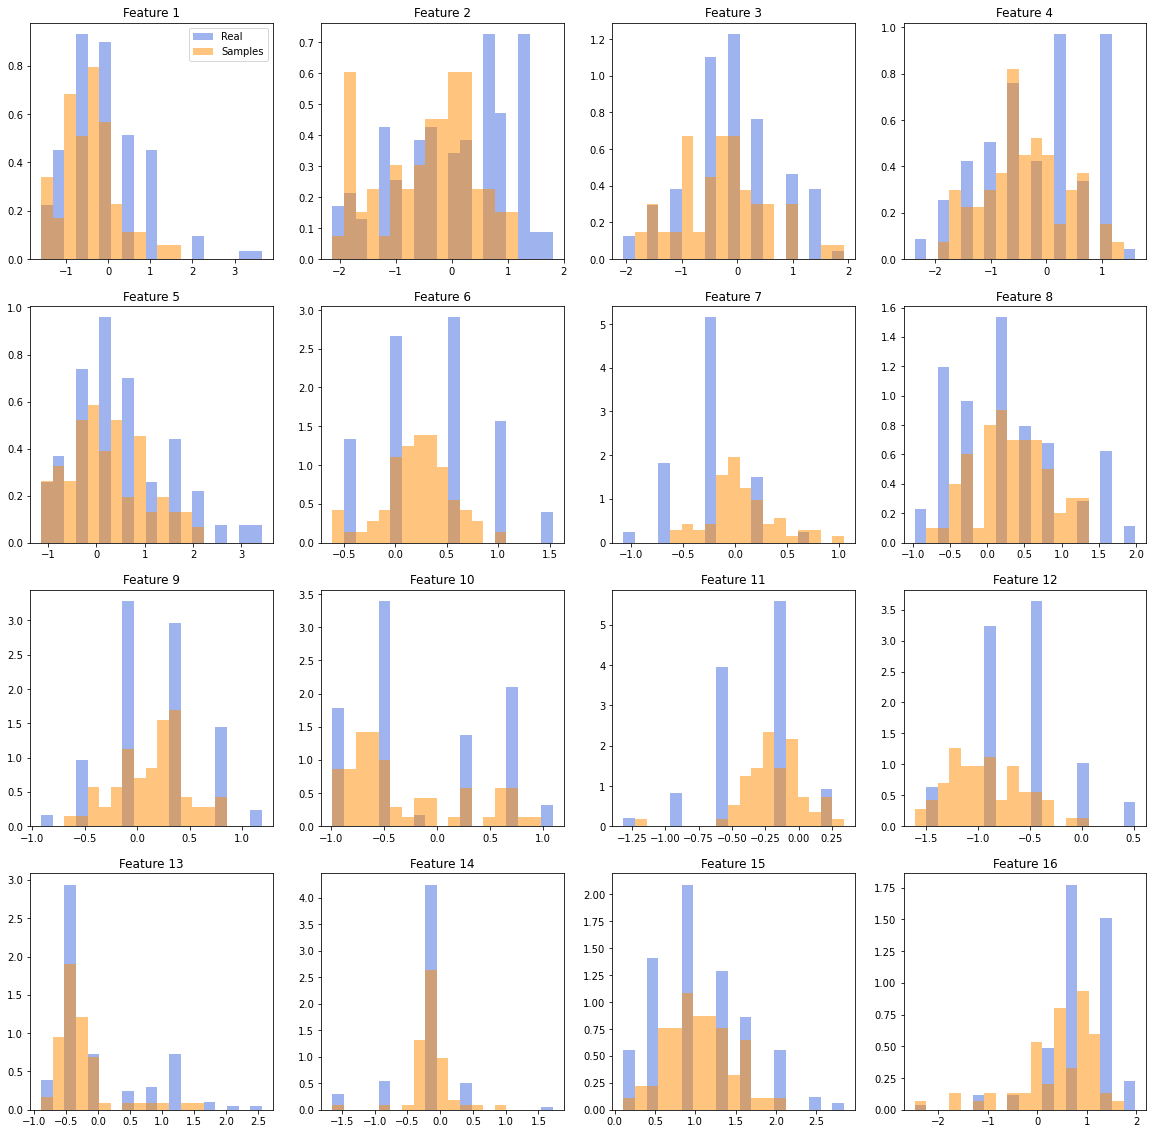

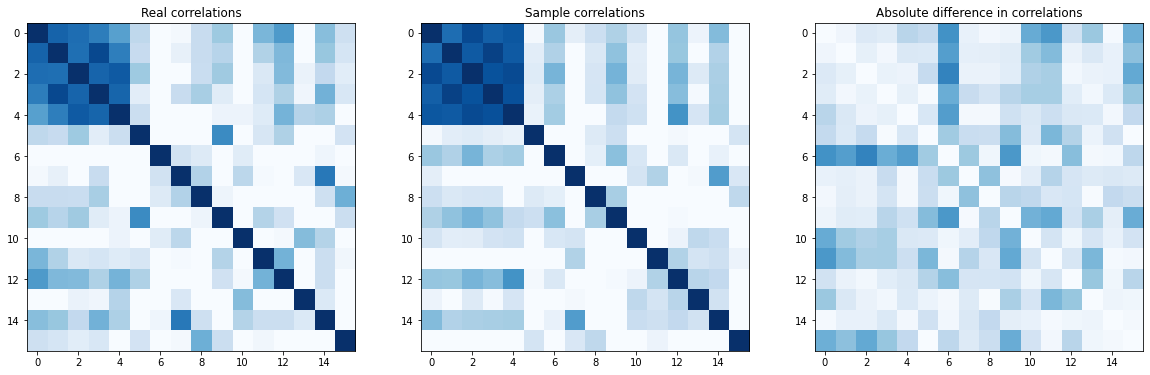

Class C


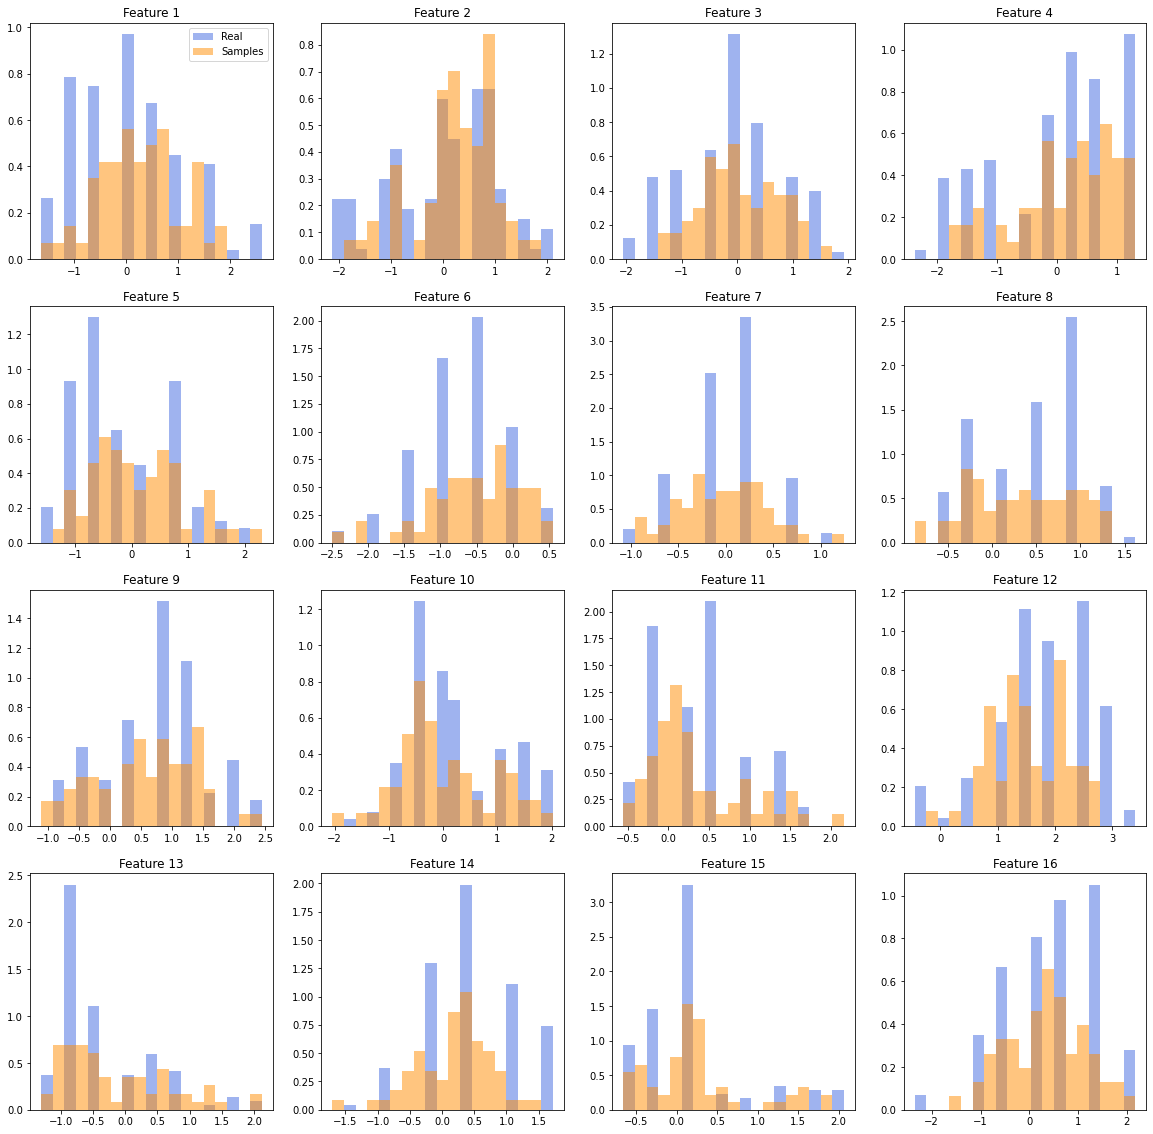

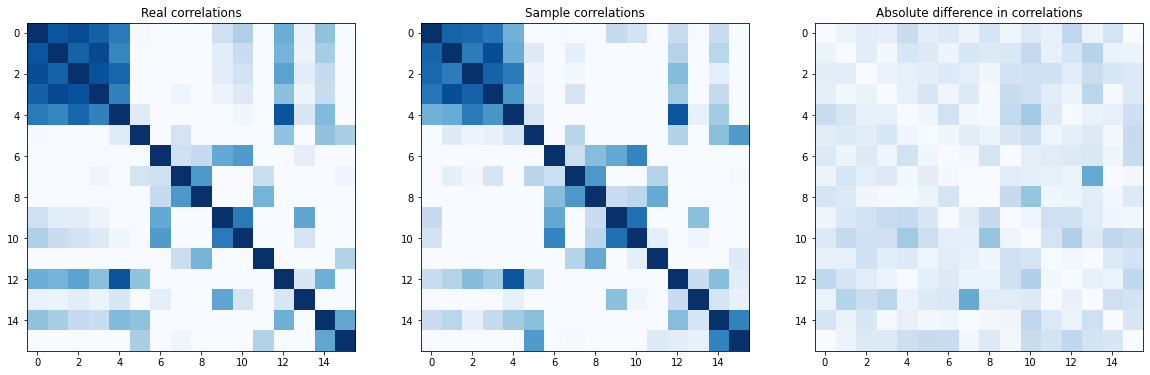

Class D


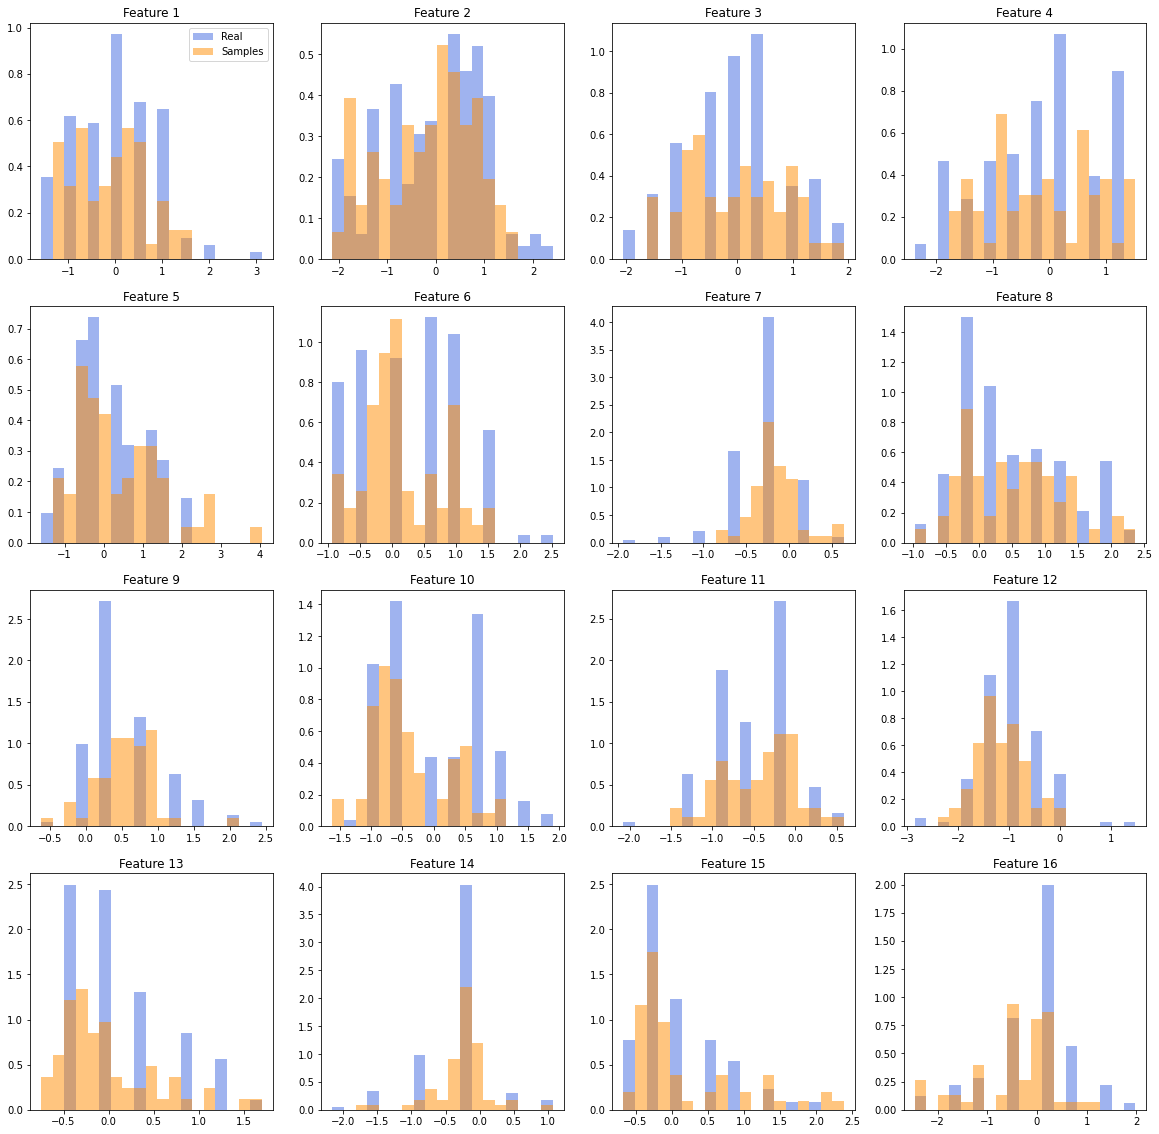

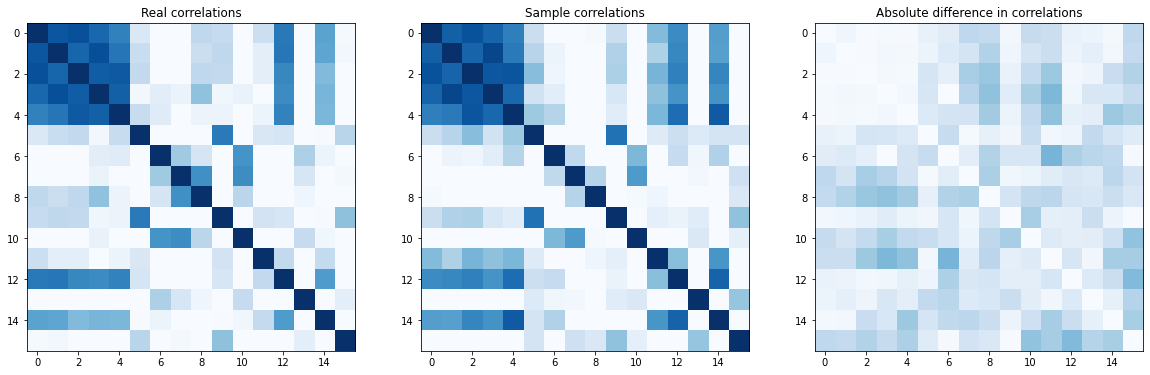

Class E


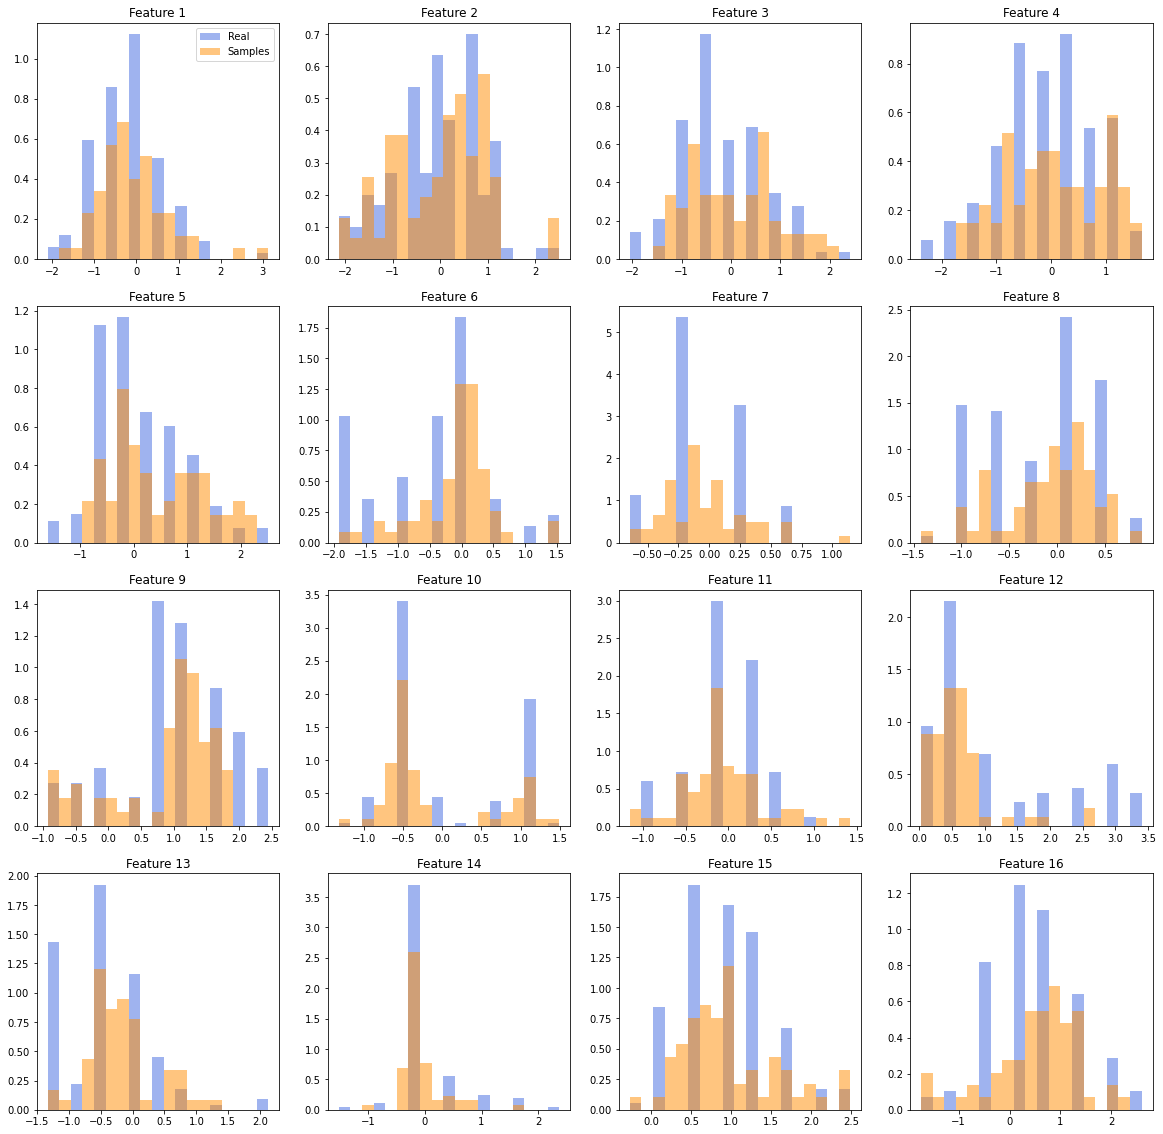

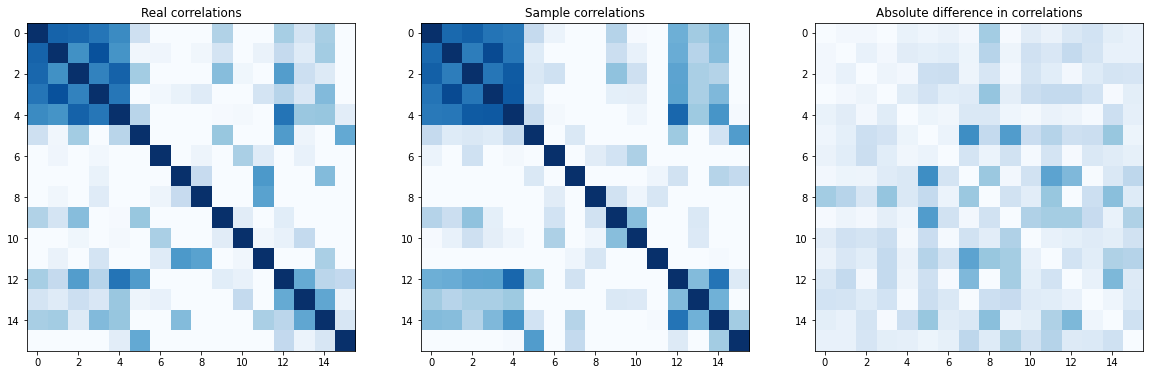

Class F


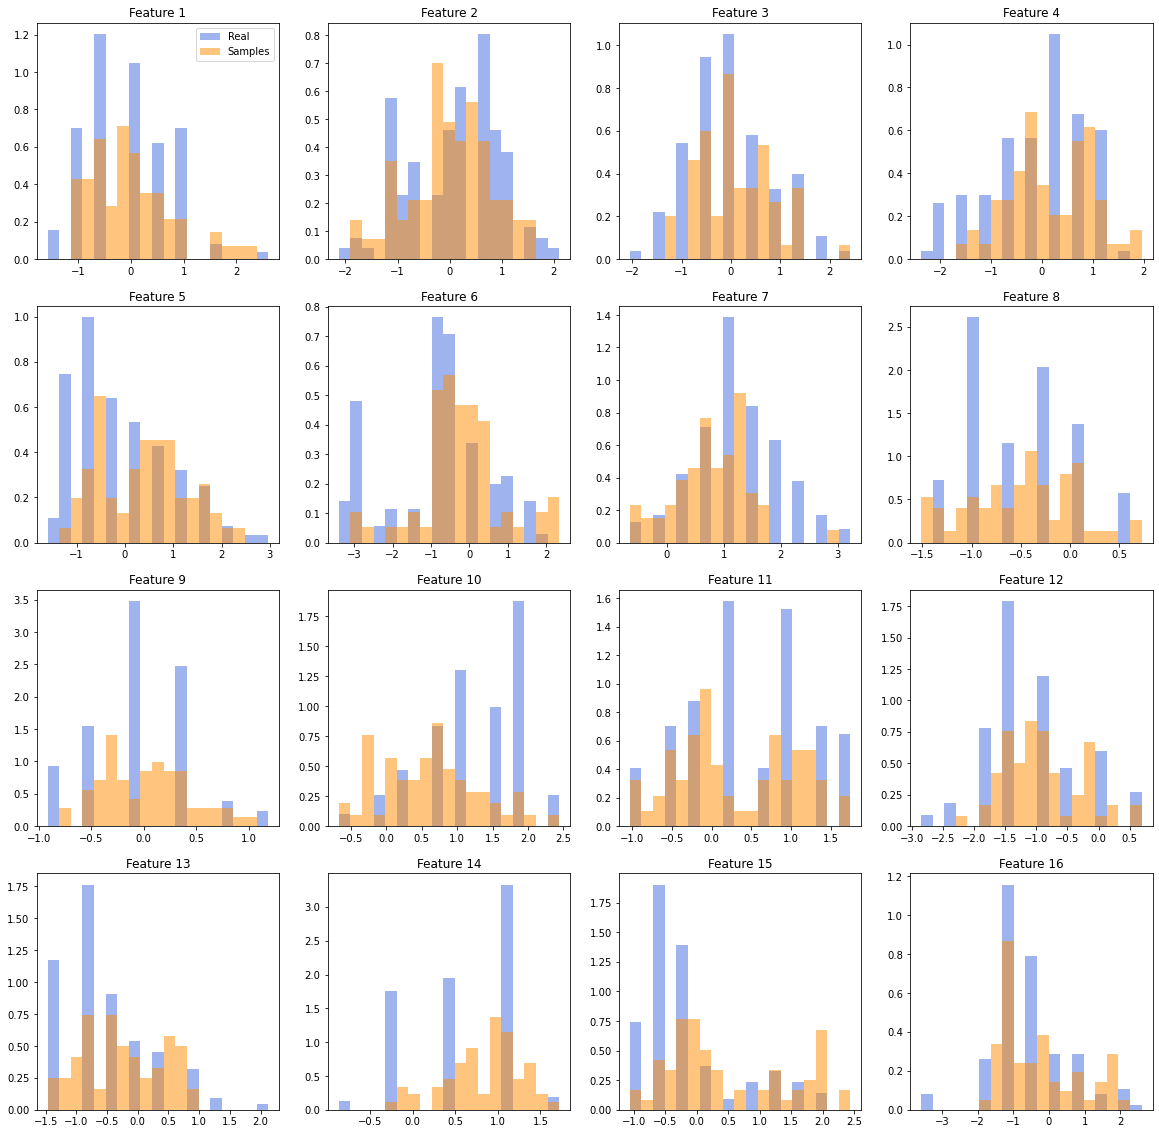

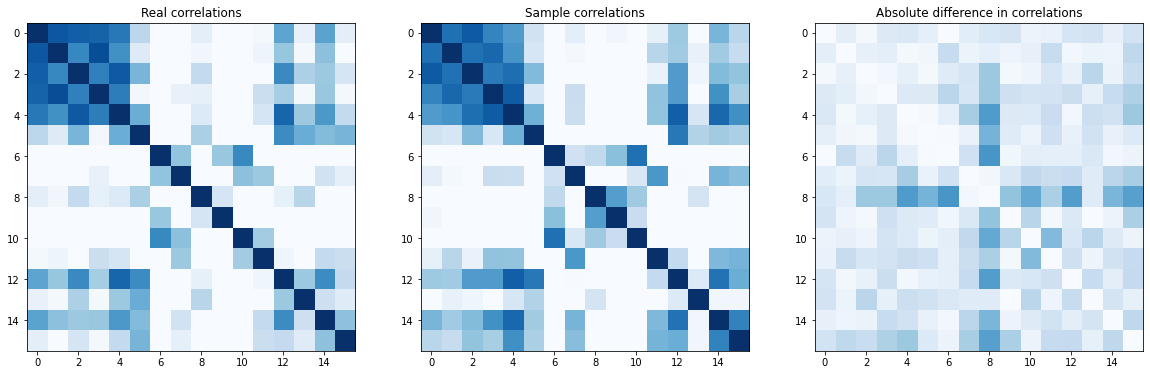

Class G


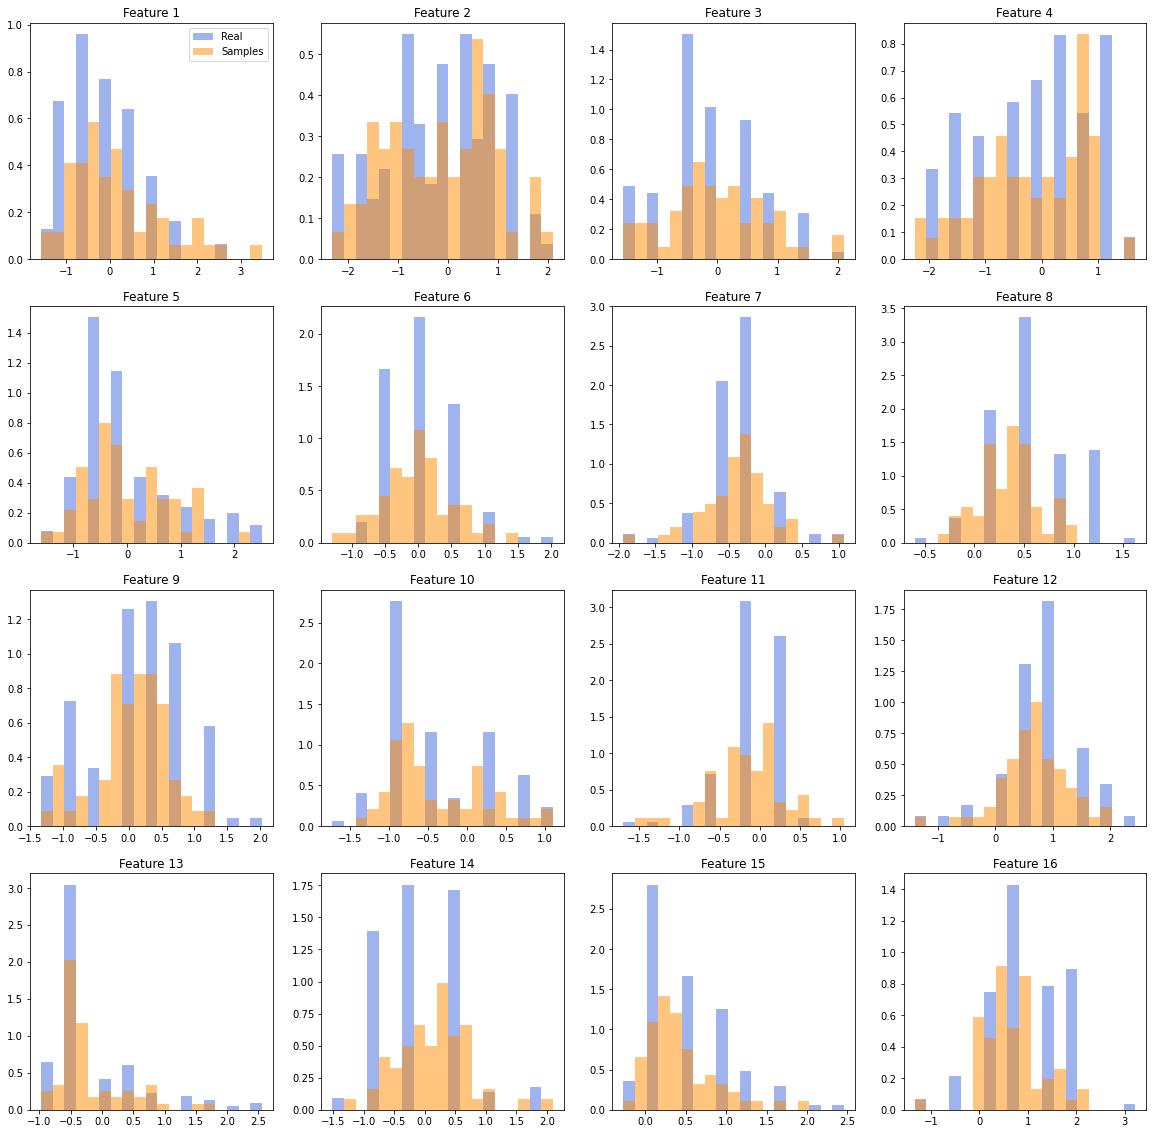

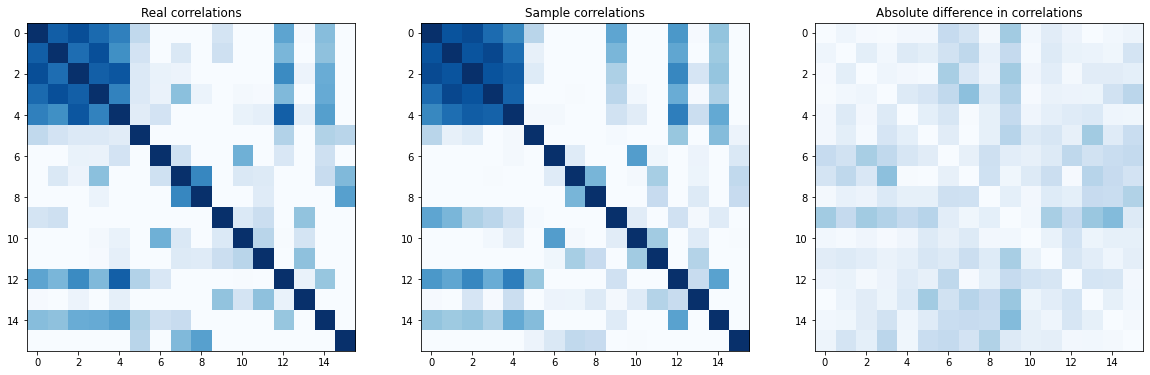

Class H


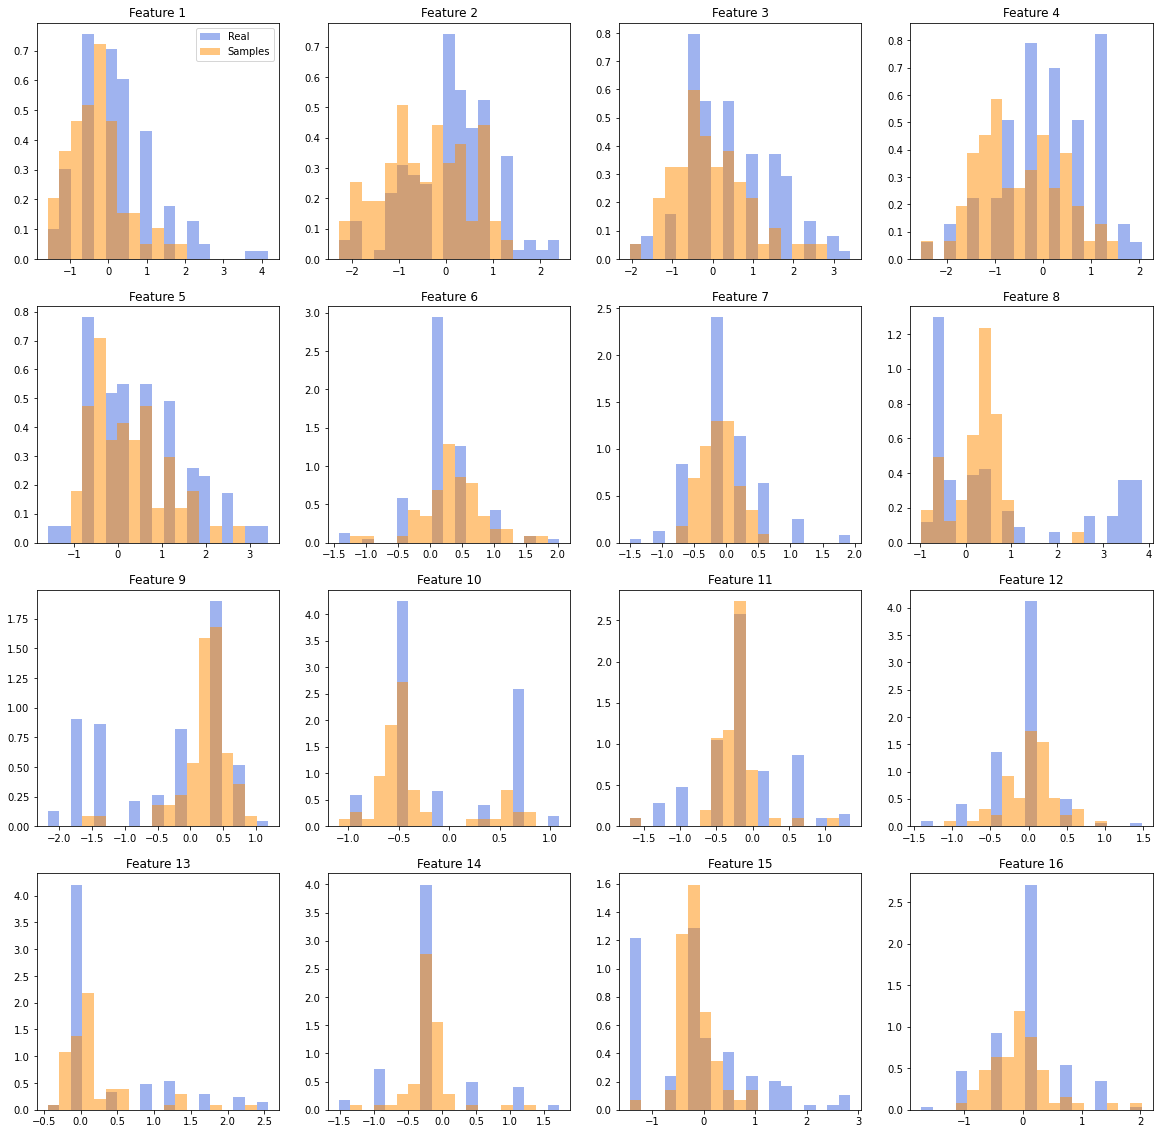

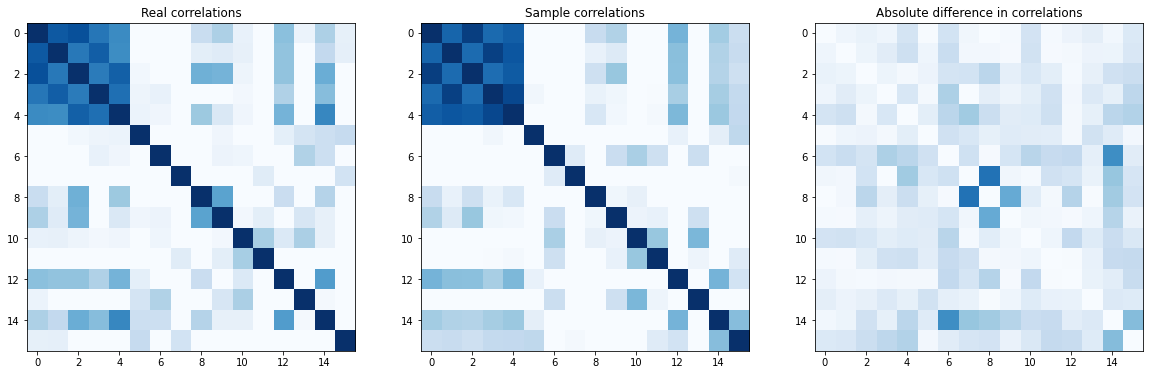

Class I


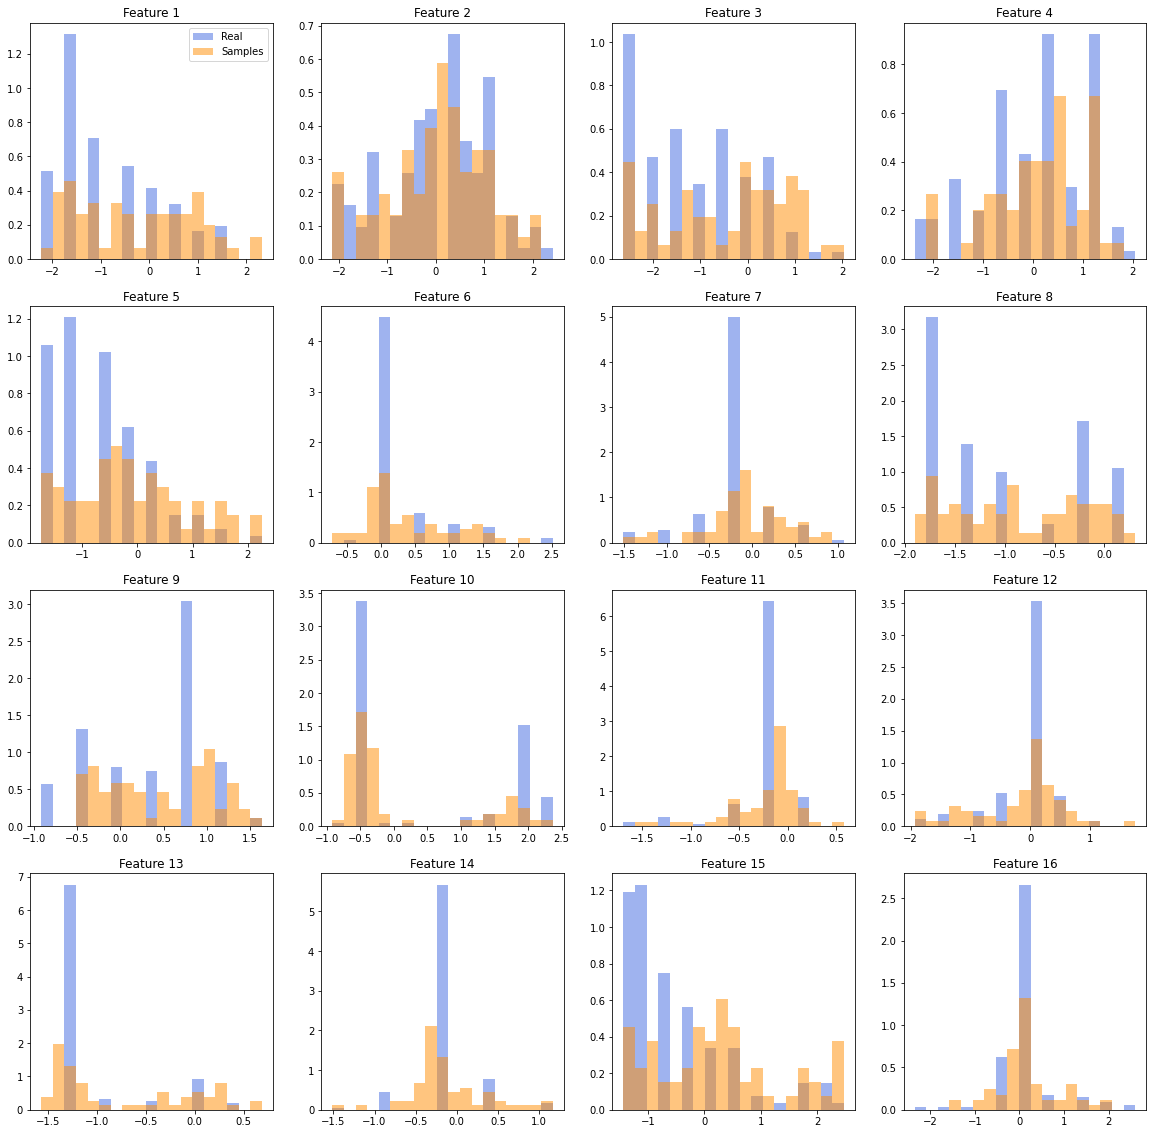

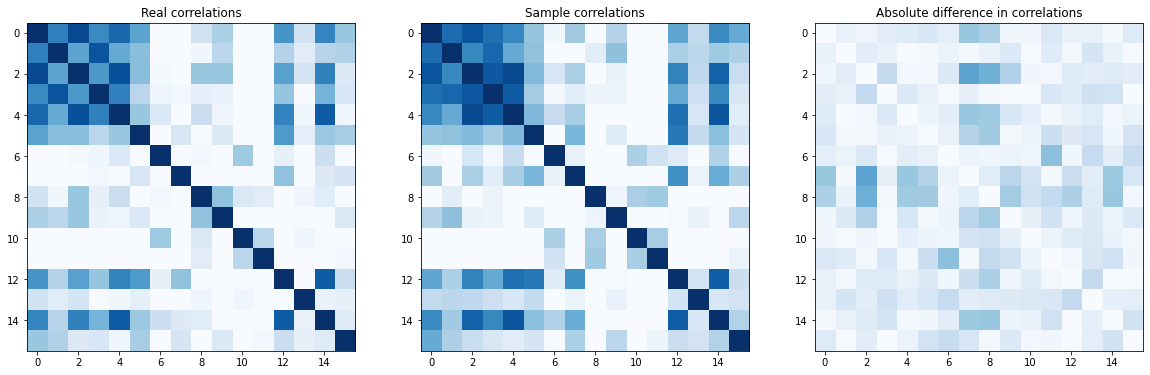

Class J


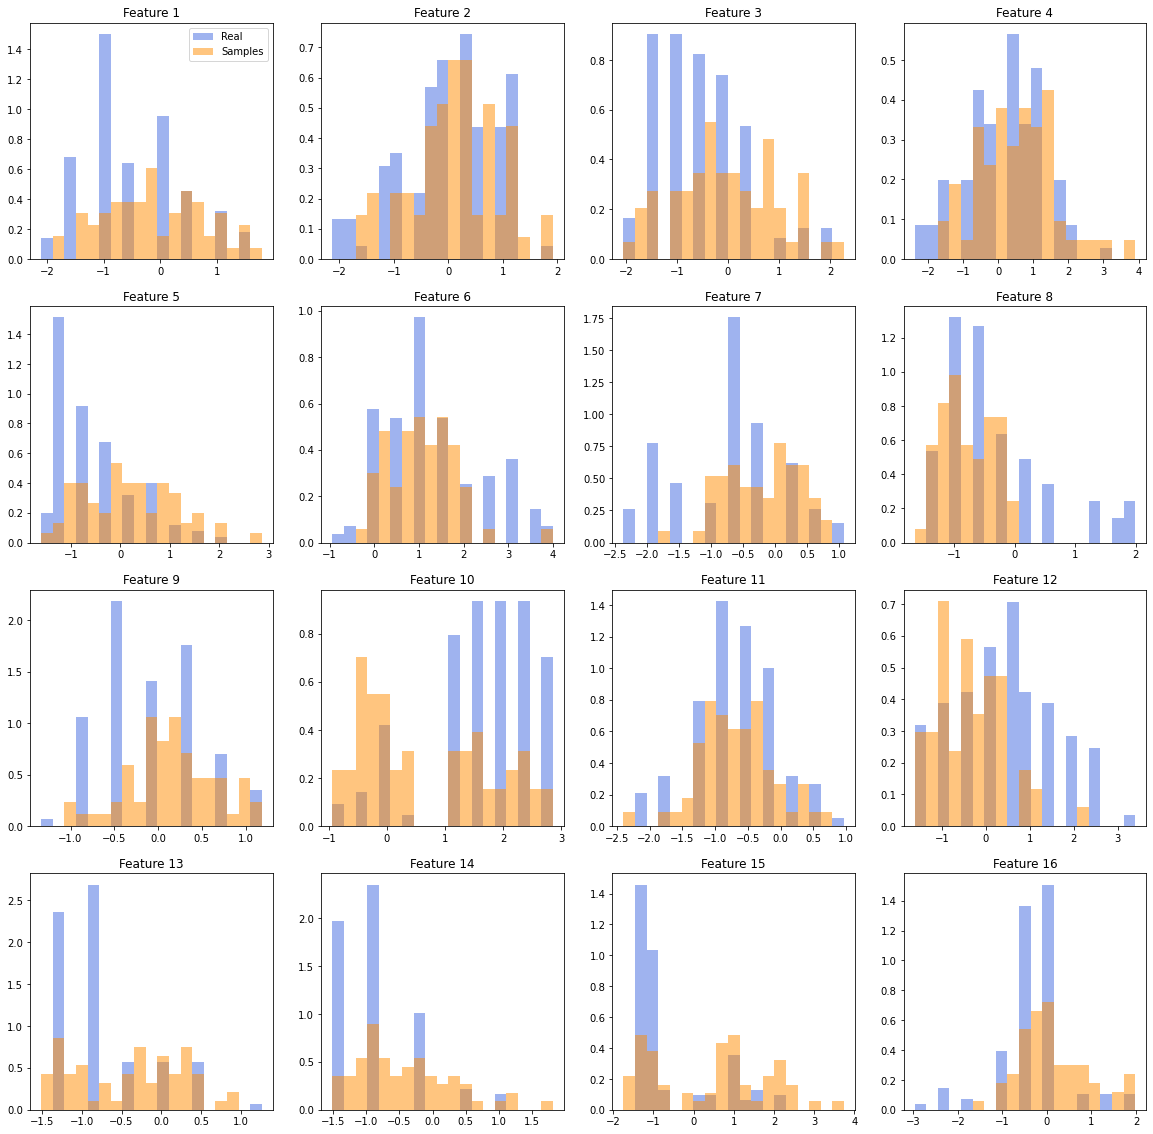

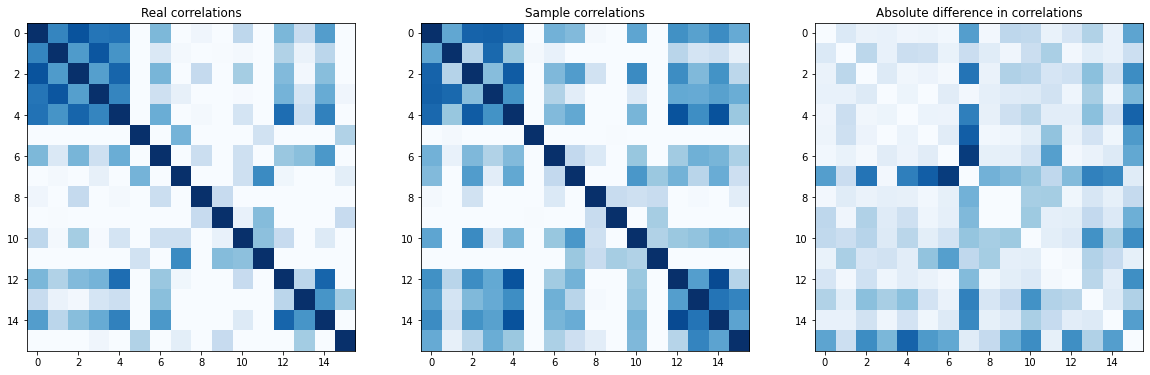

Class K


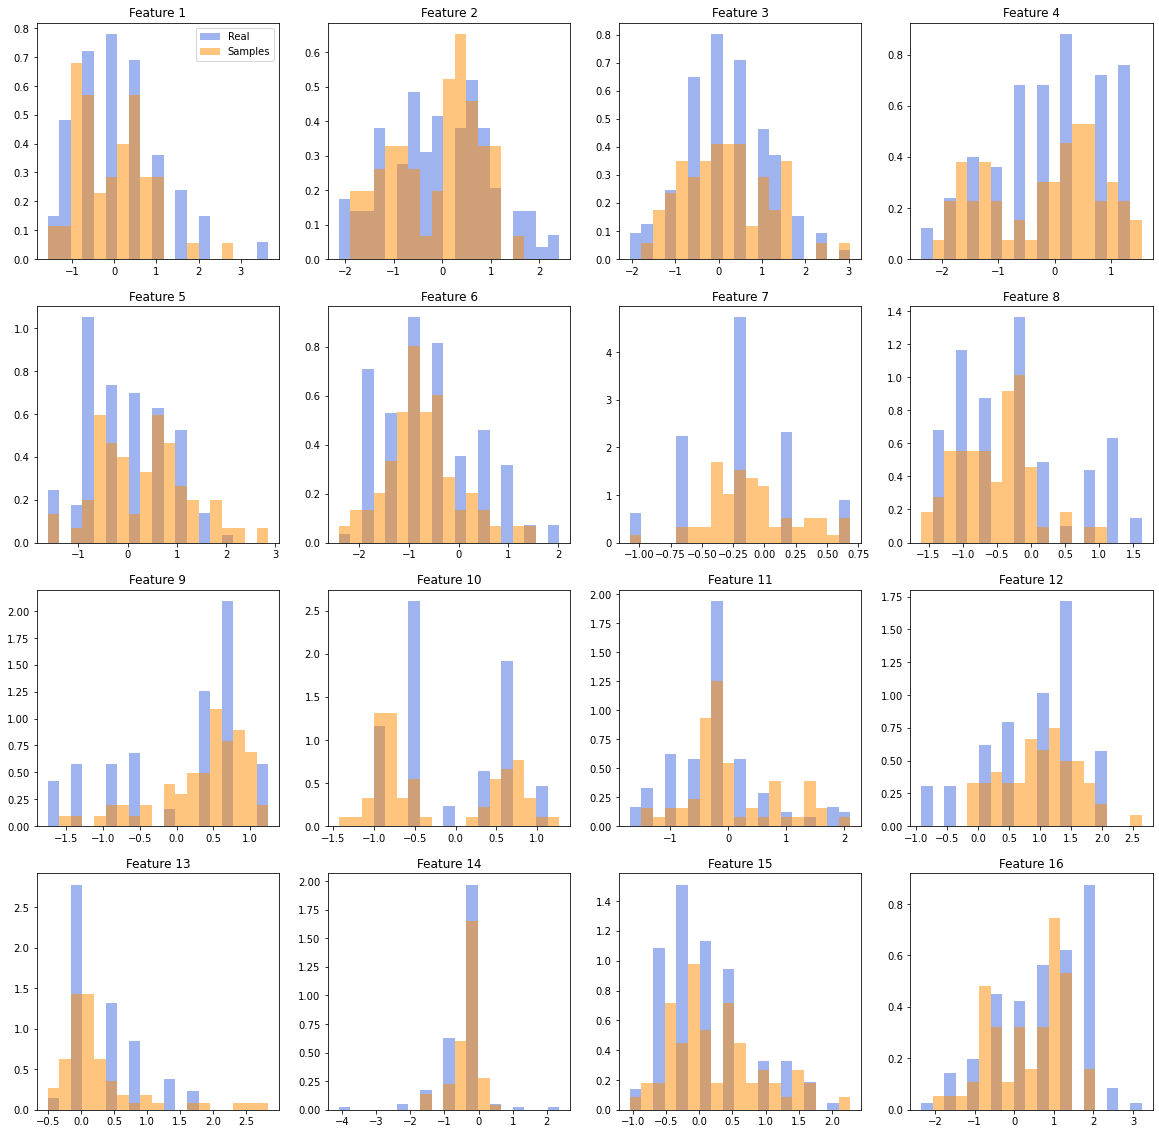

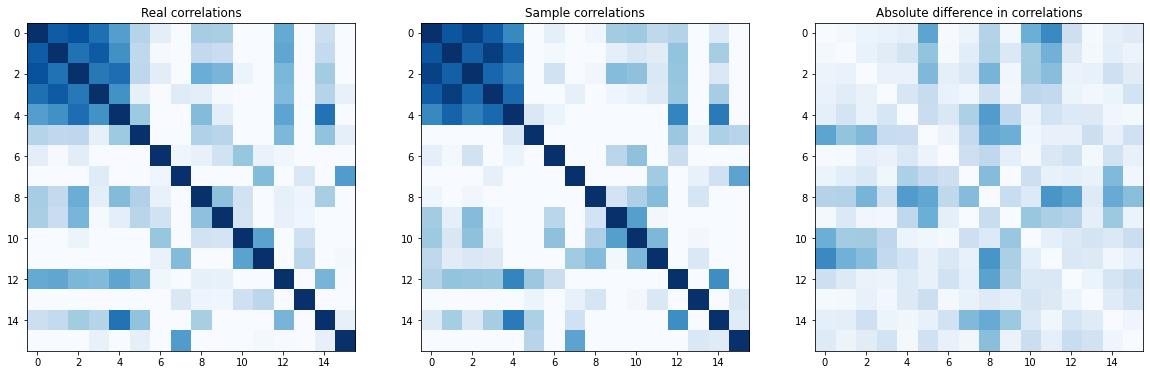

Class L


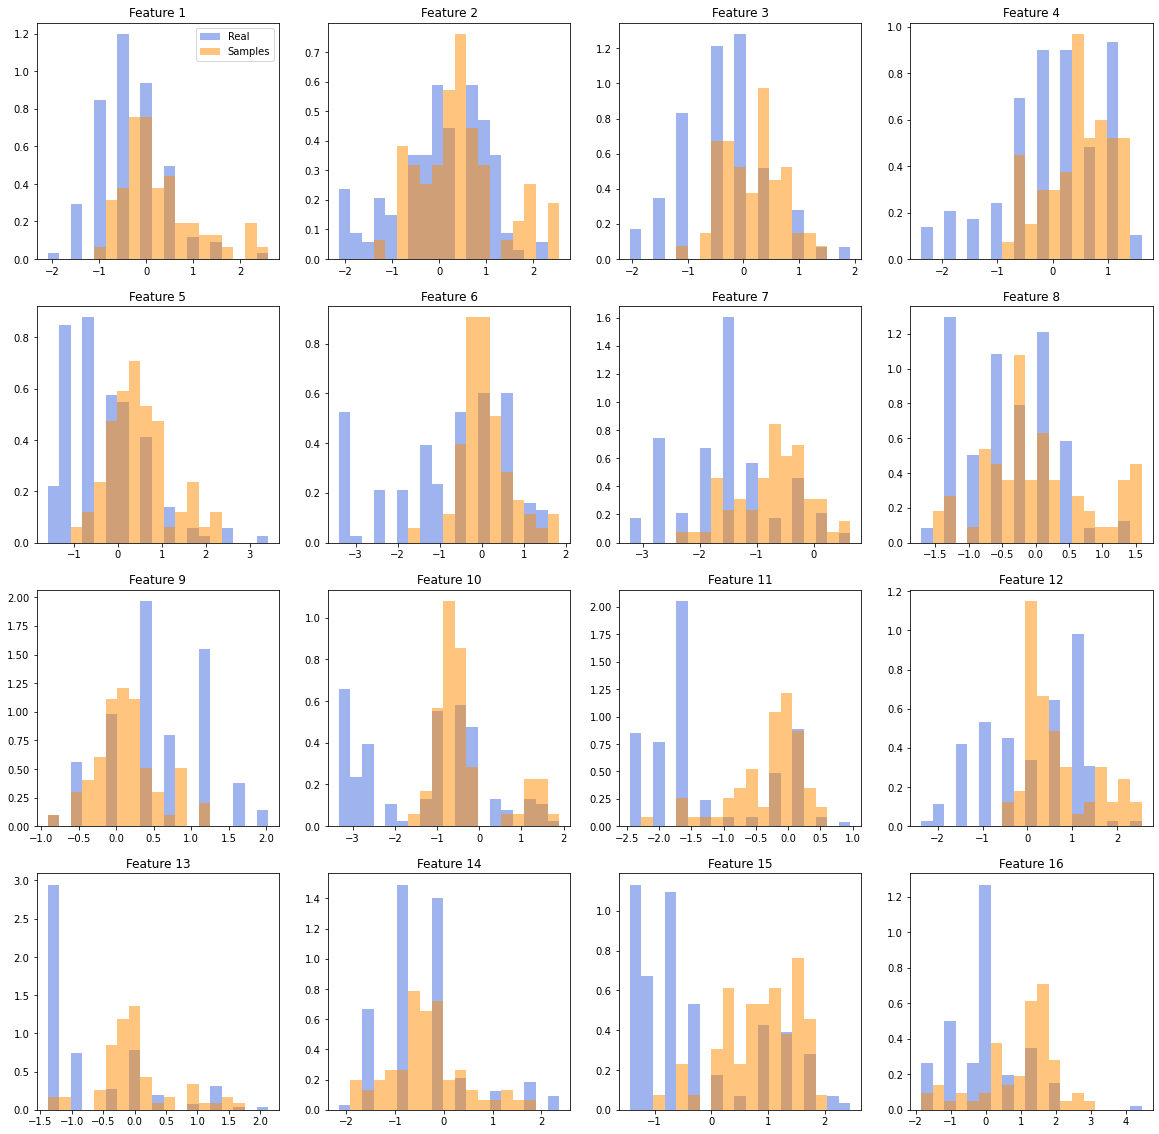

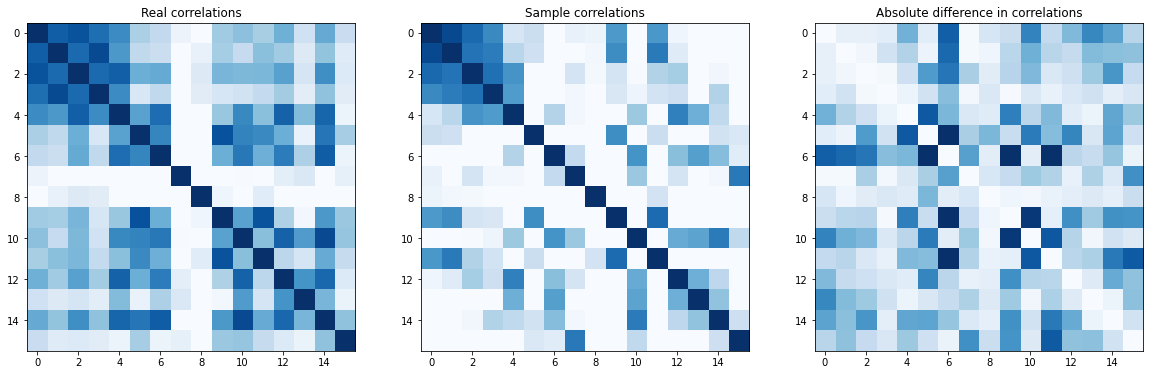

Class M


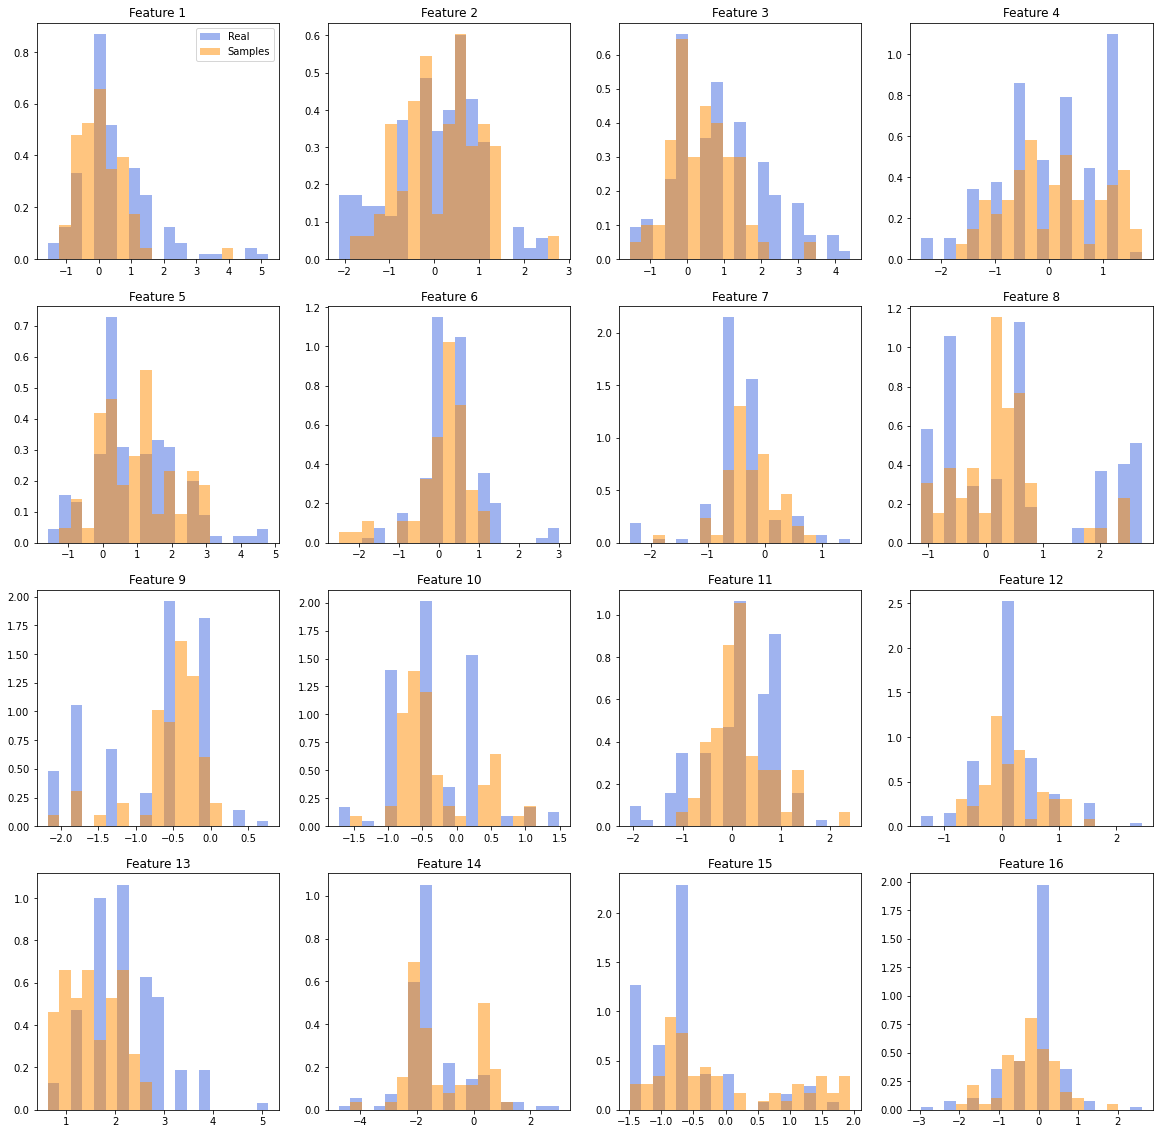

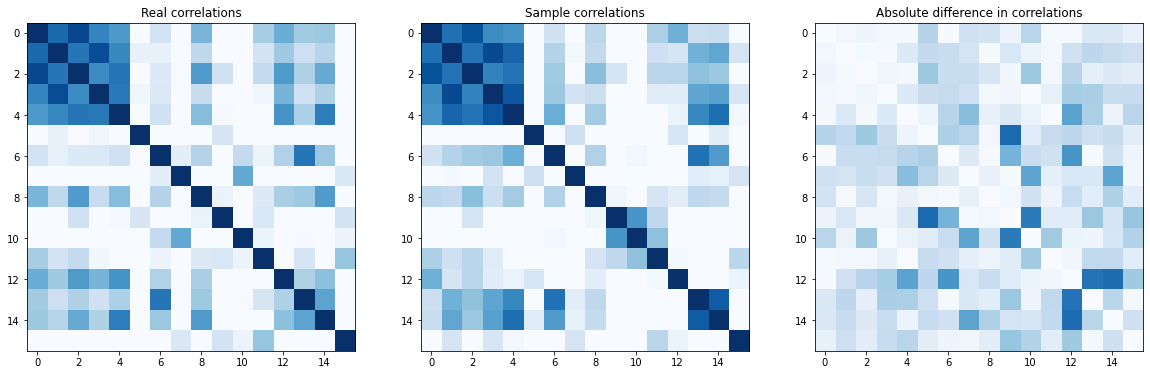

Class N


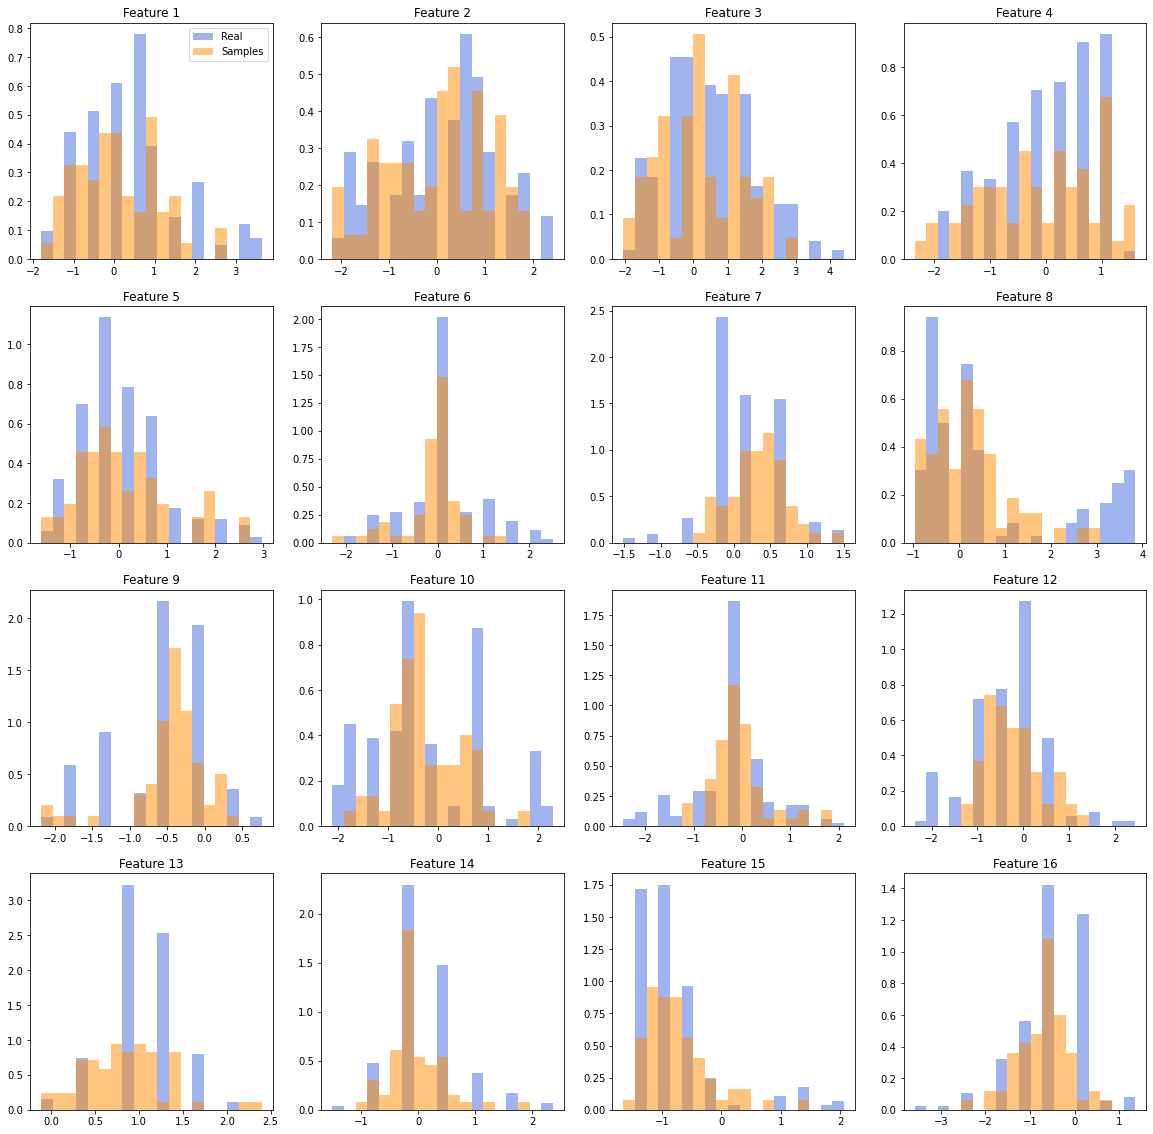

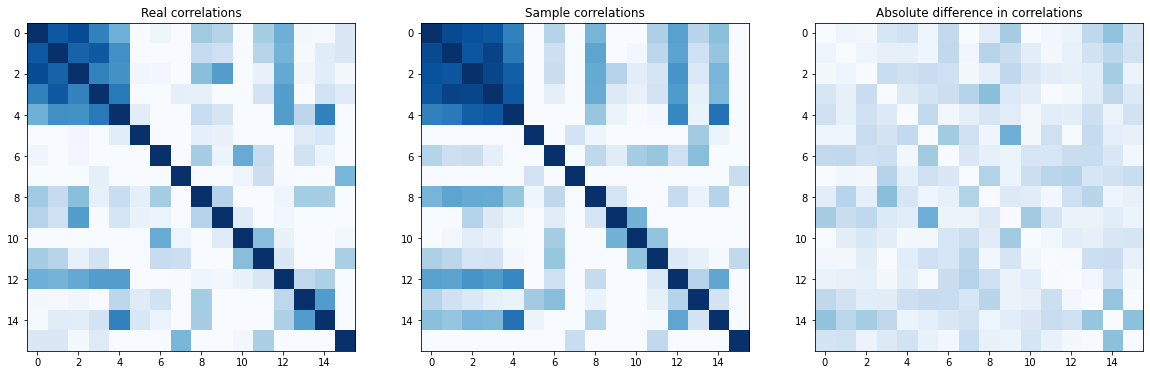

Class O


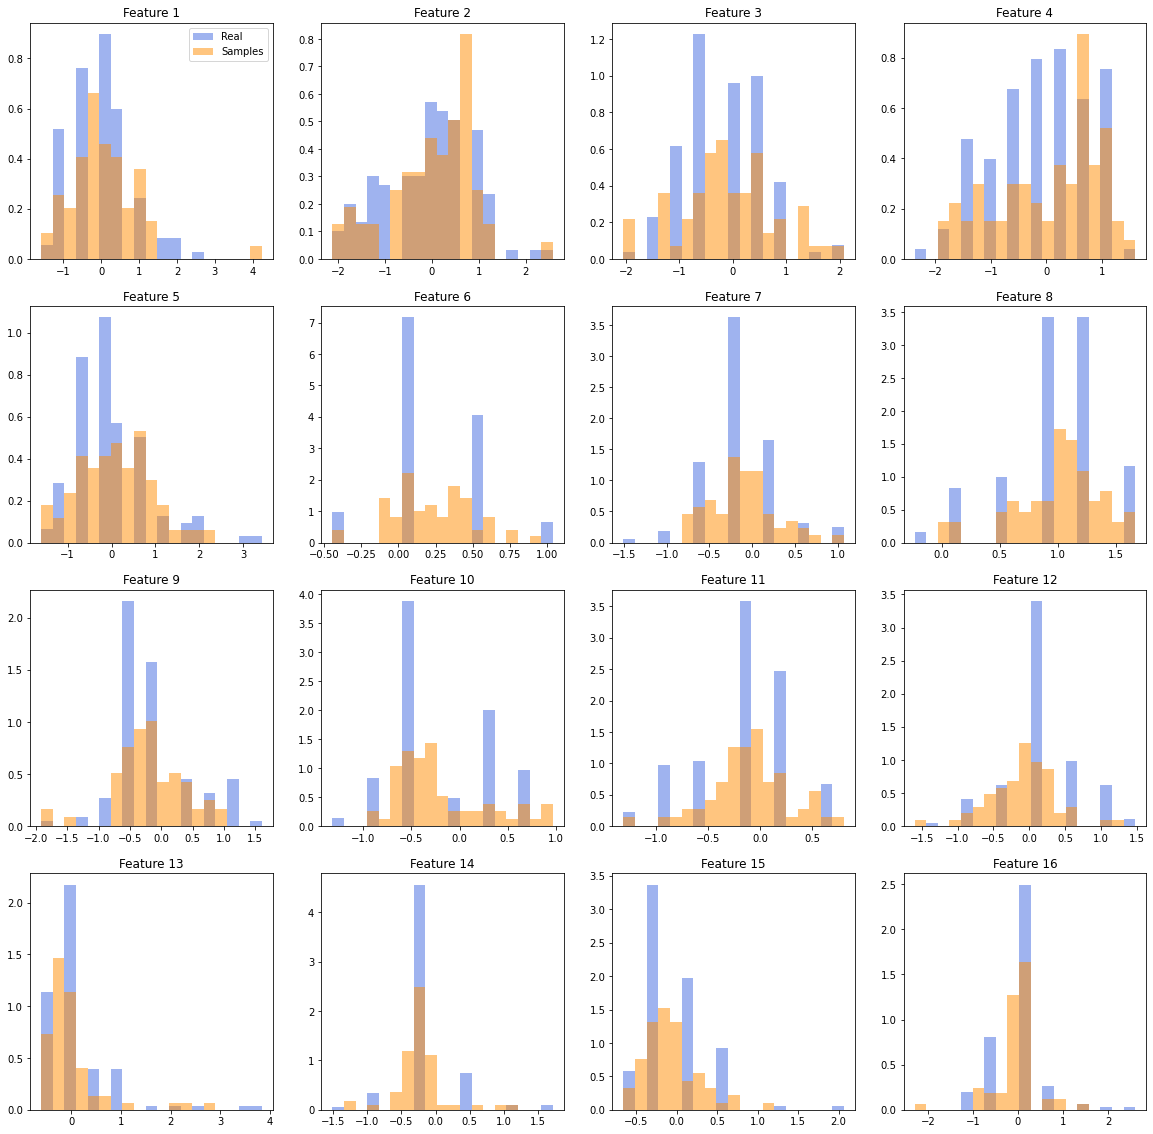

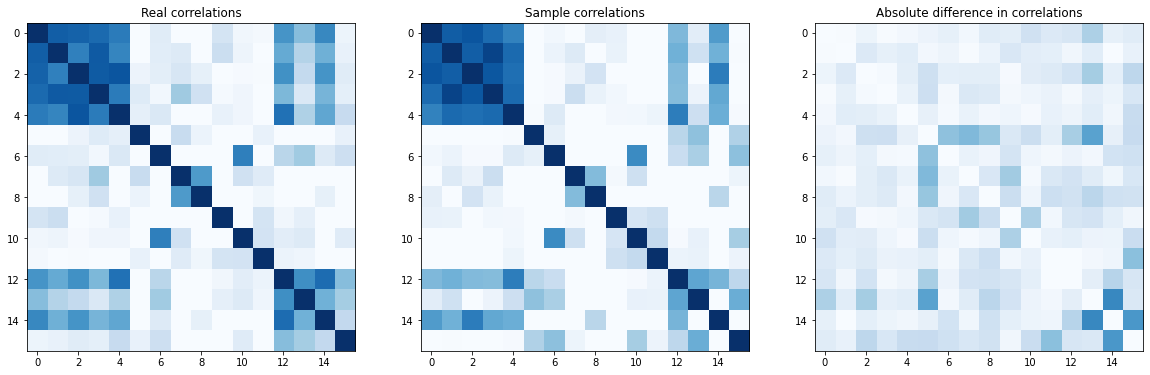

Class P


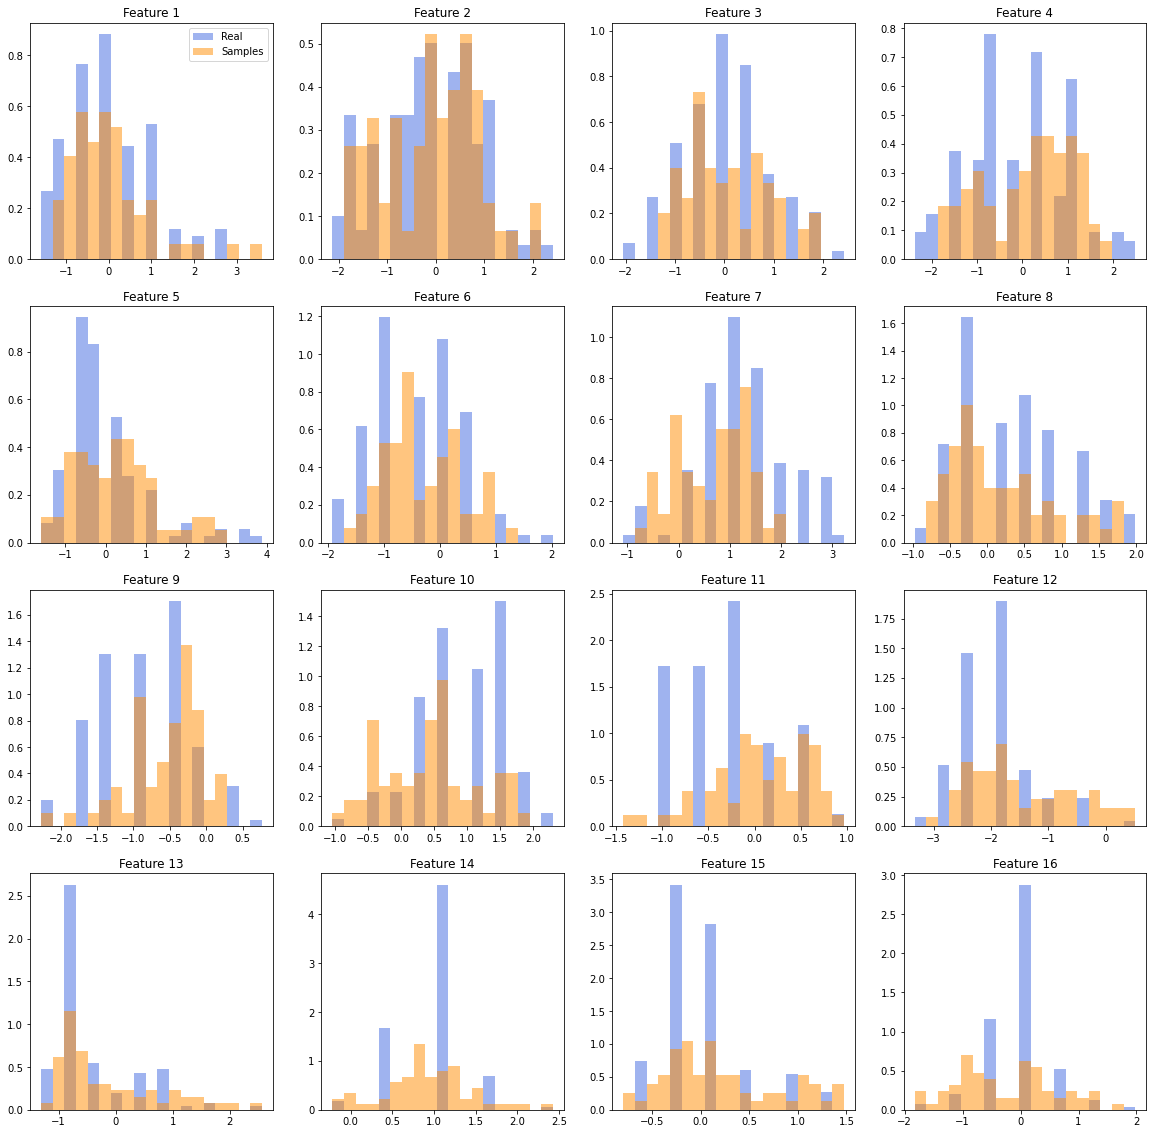

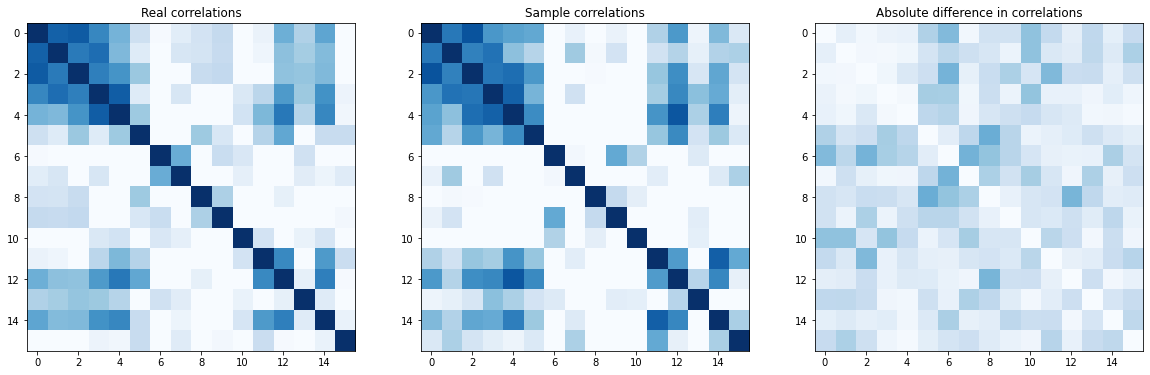

Class Q


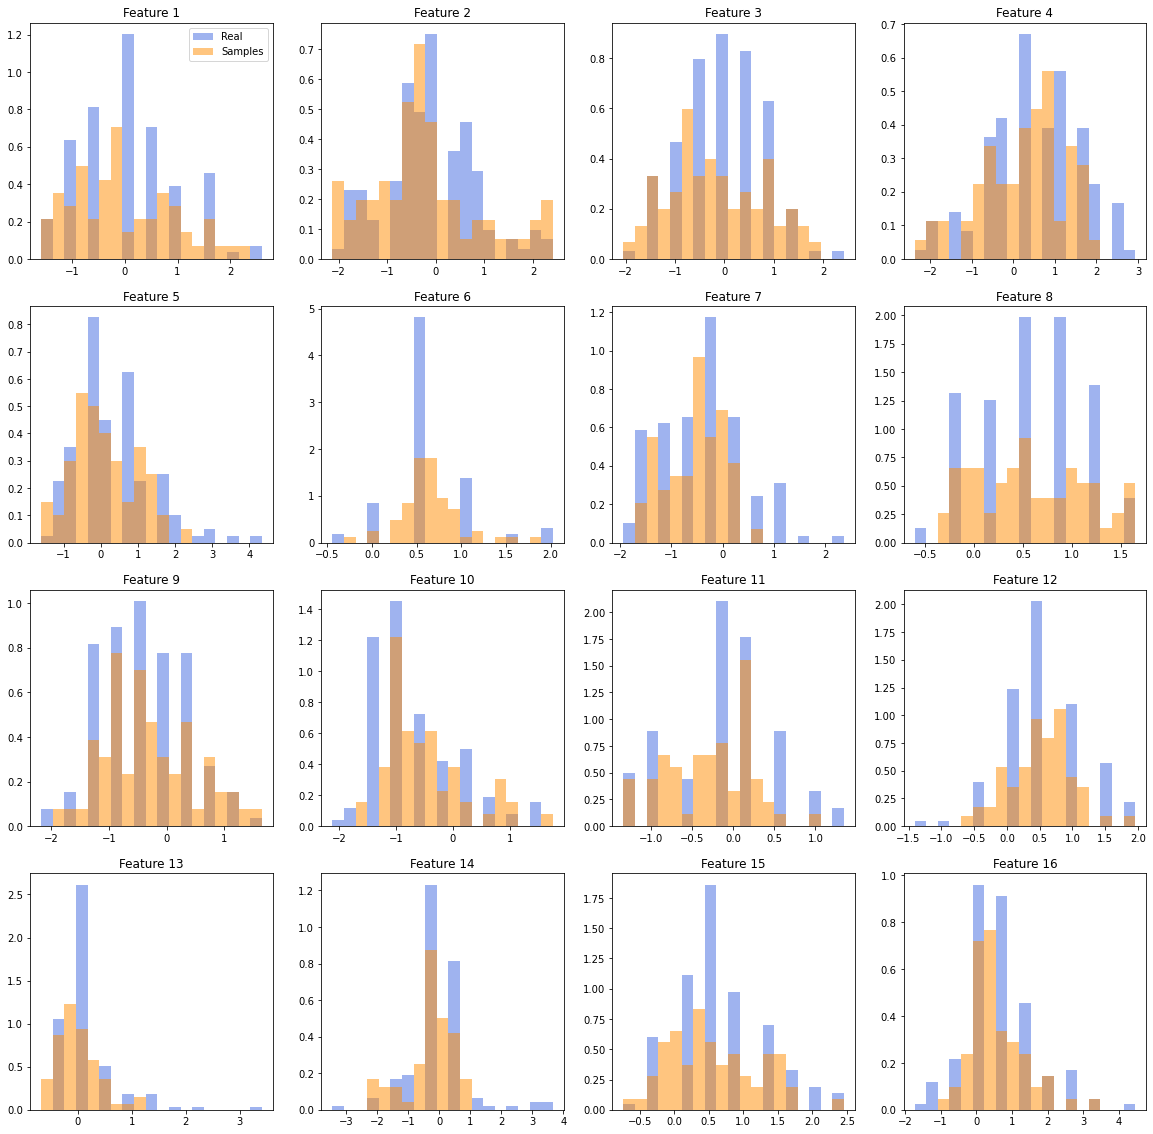

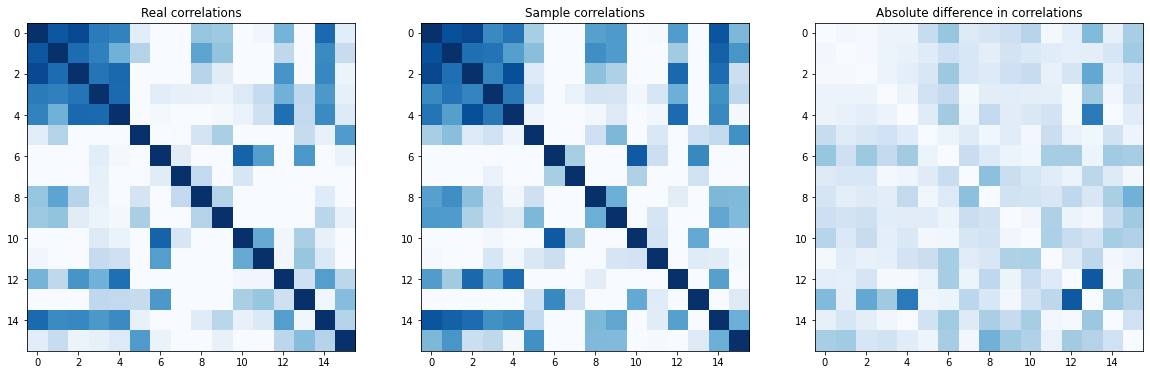

Class R


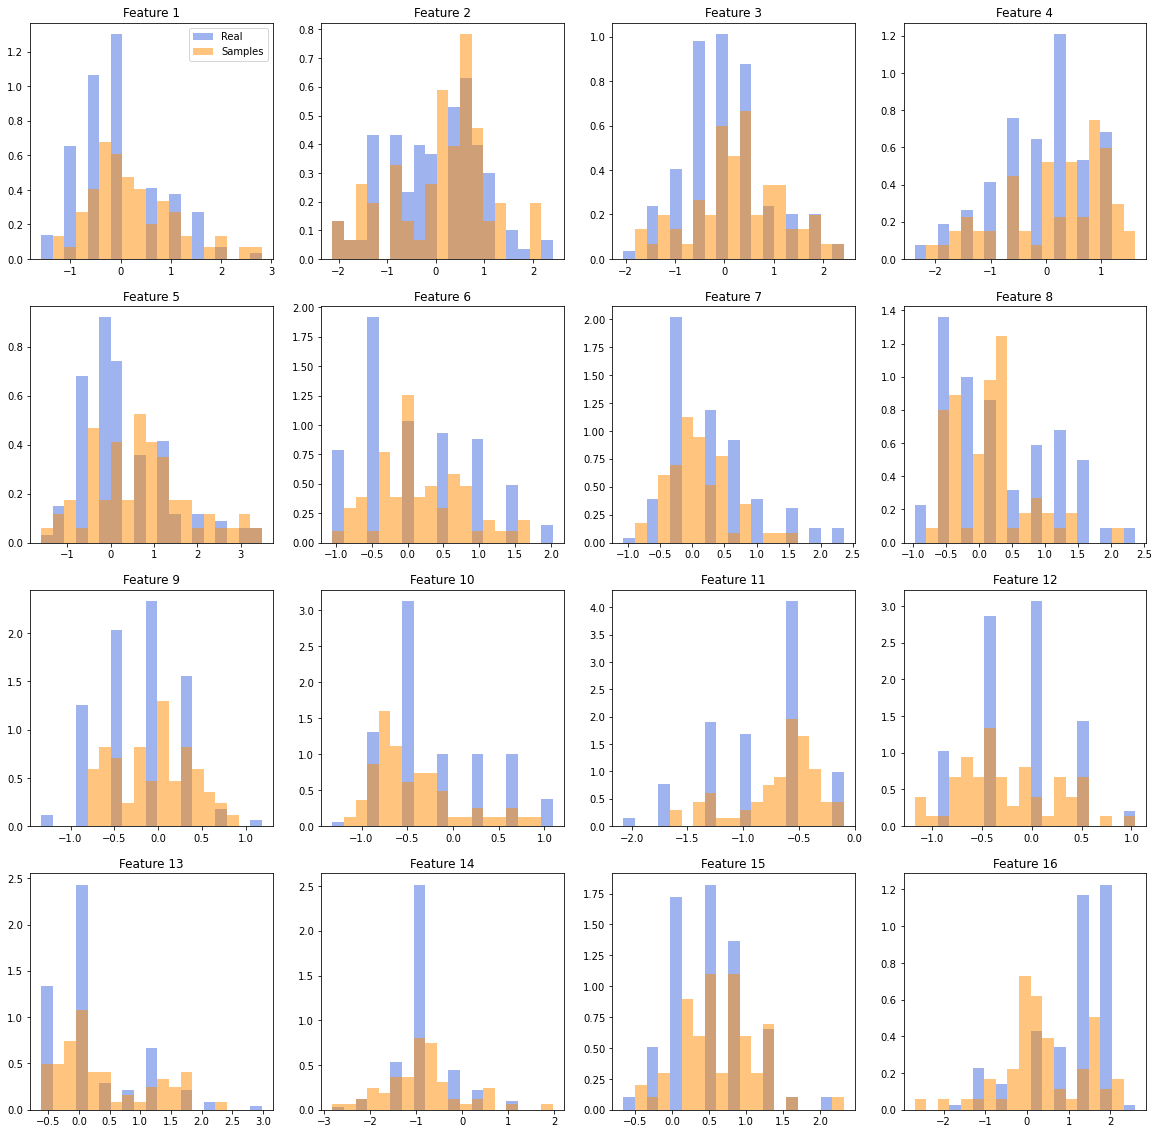

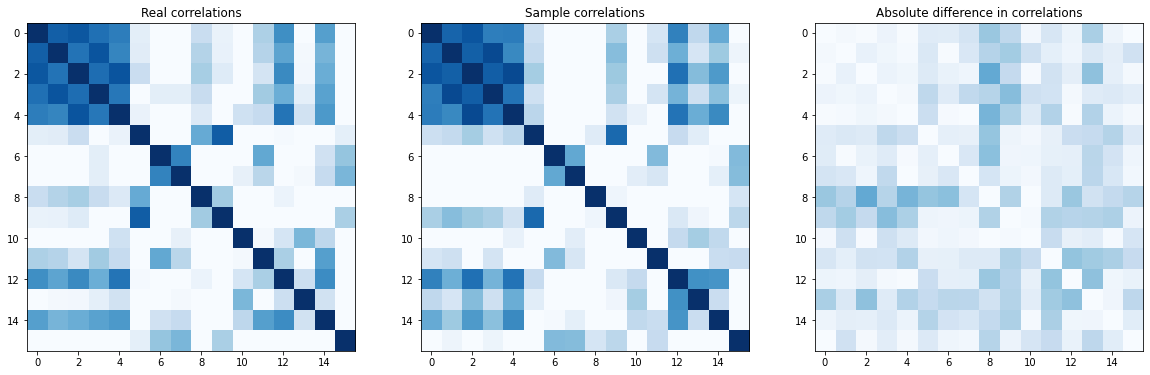

Class S


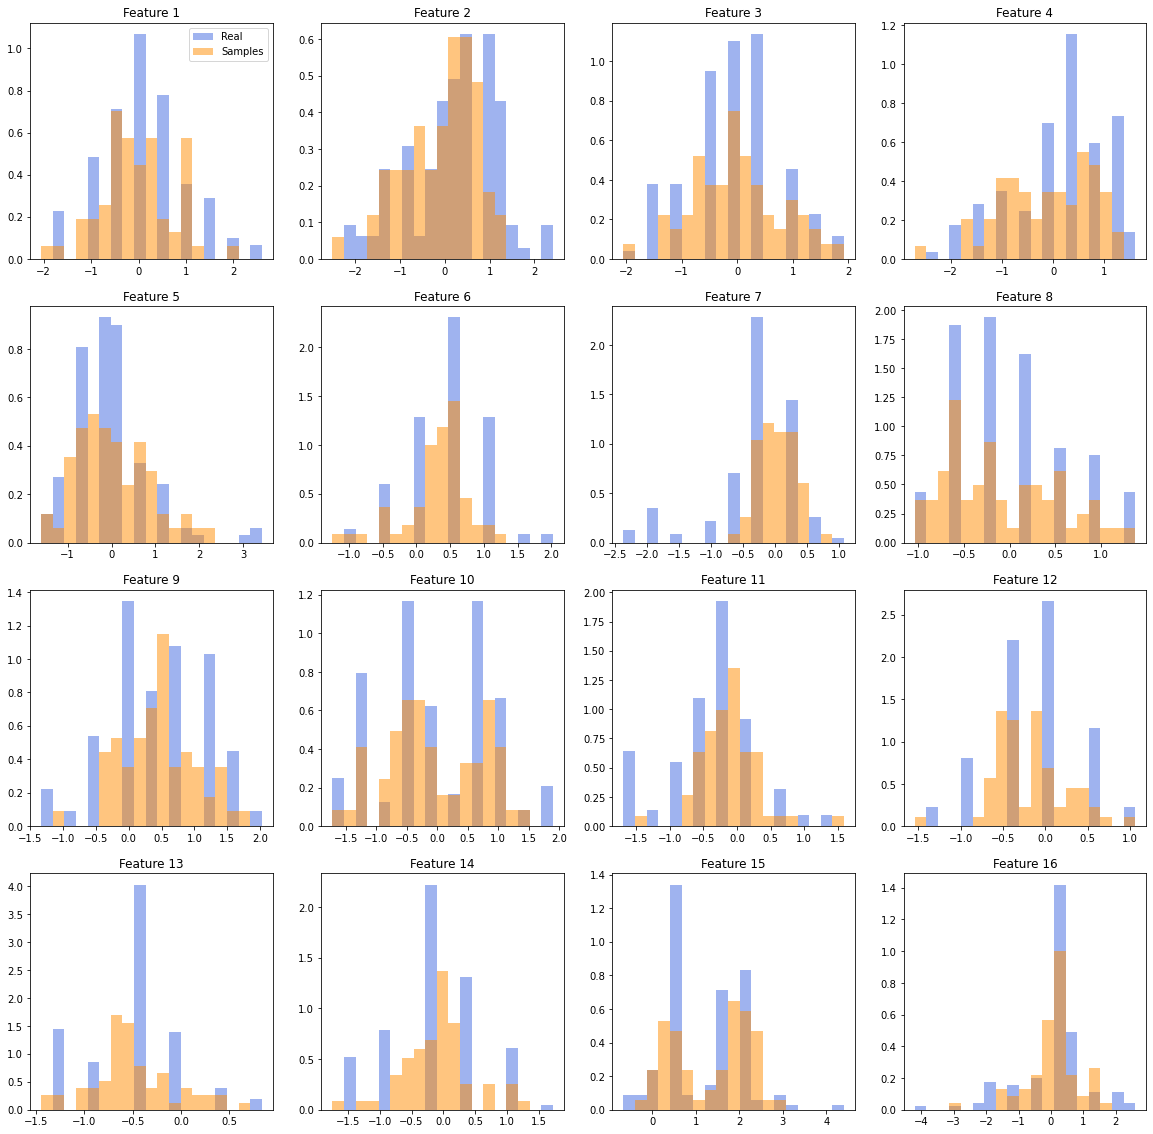

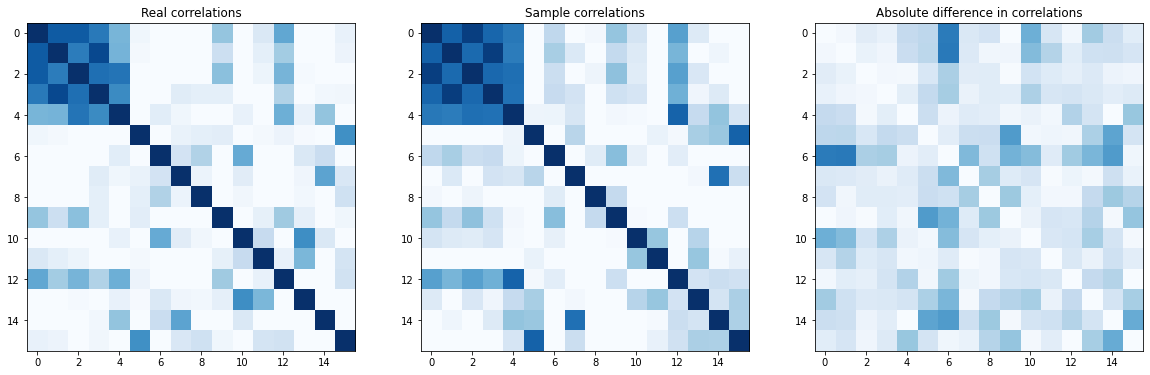

Class T


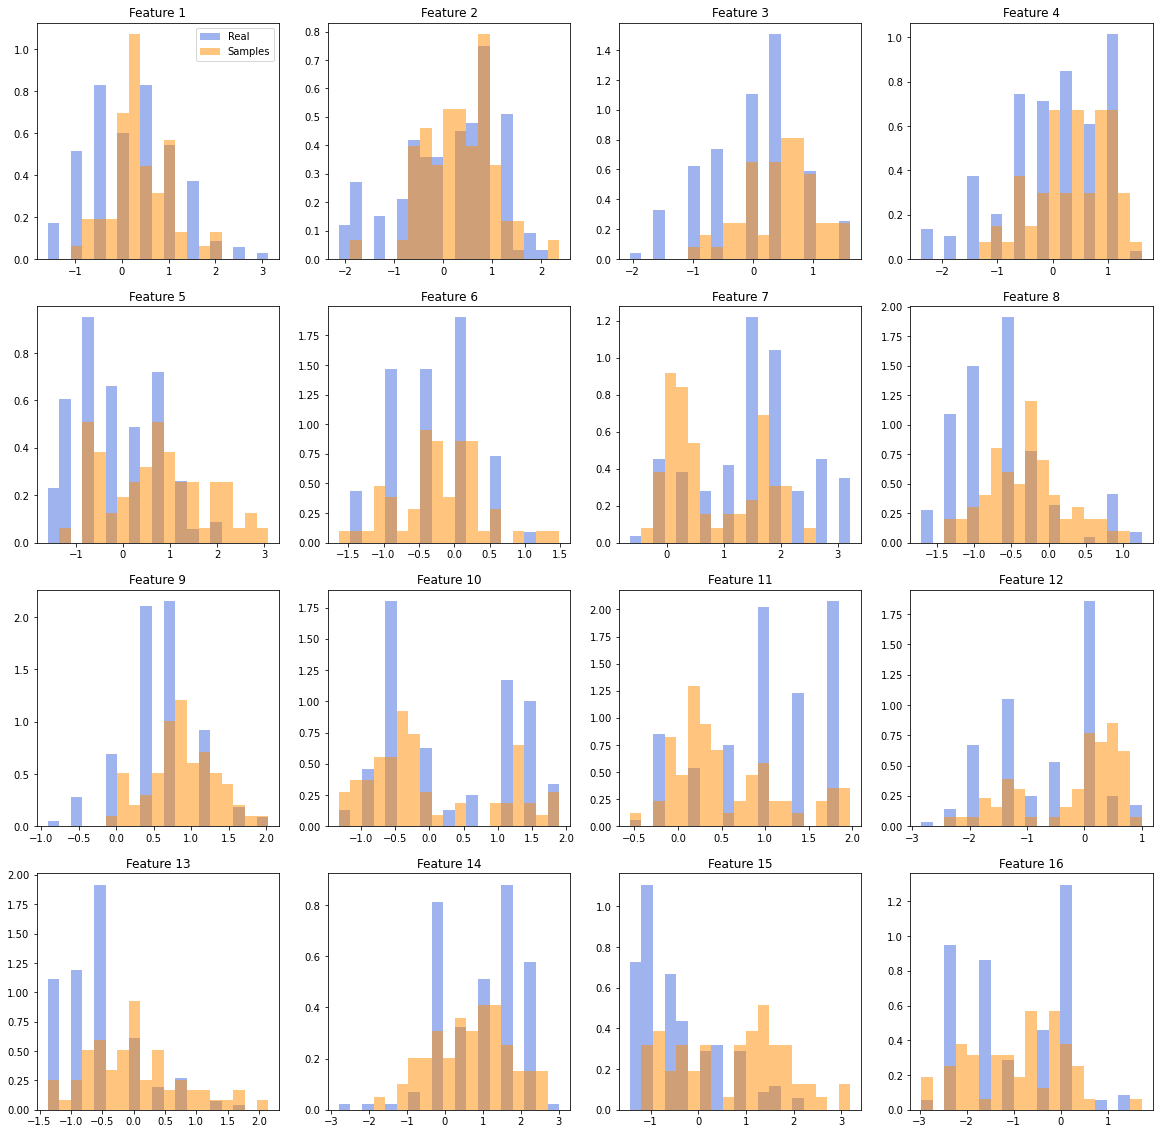

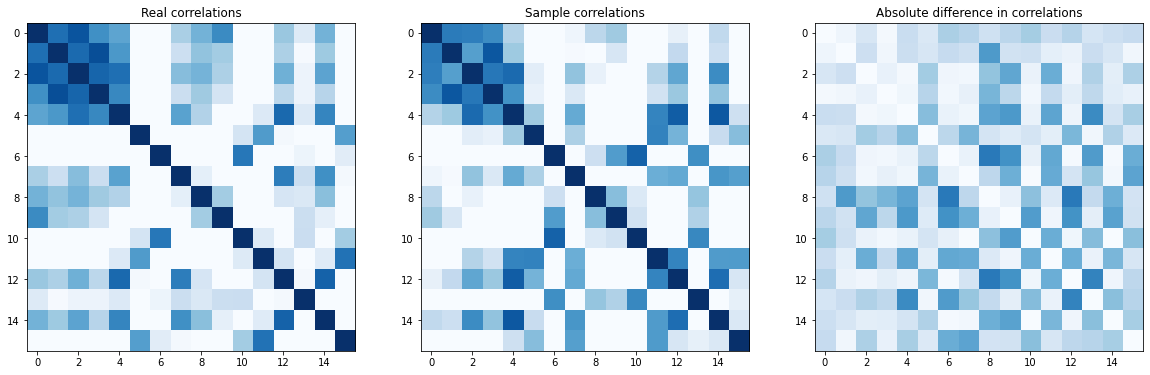

Class U


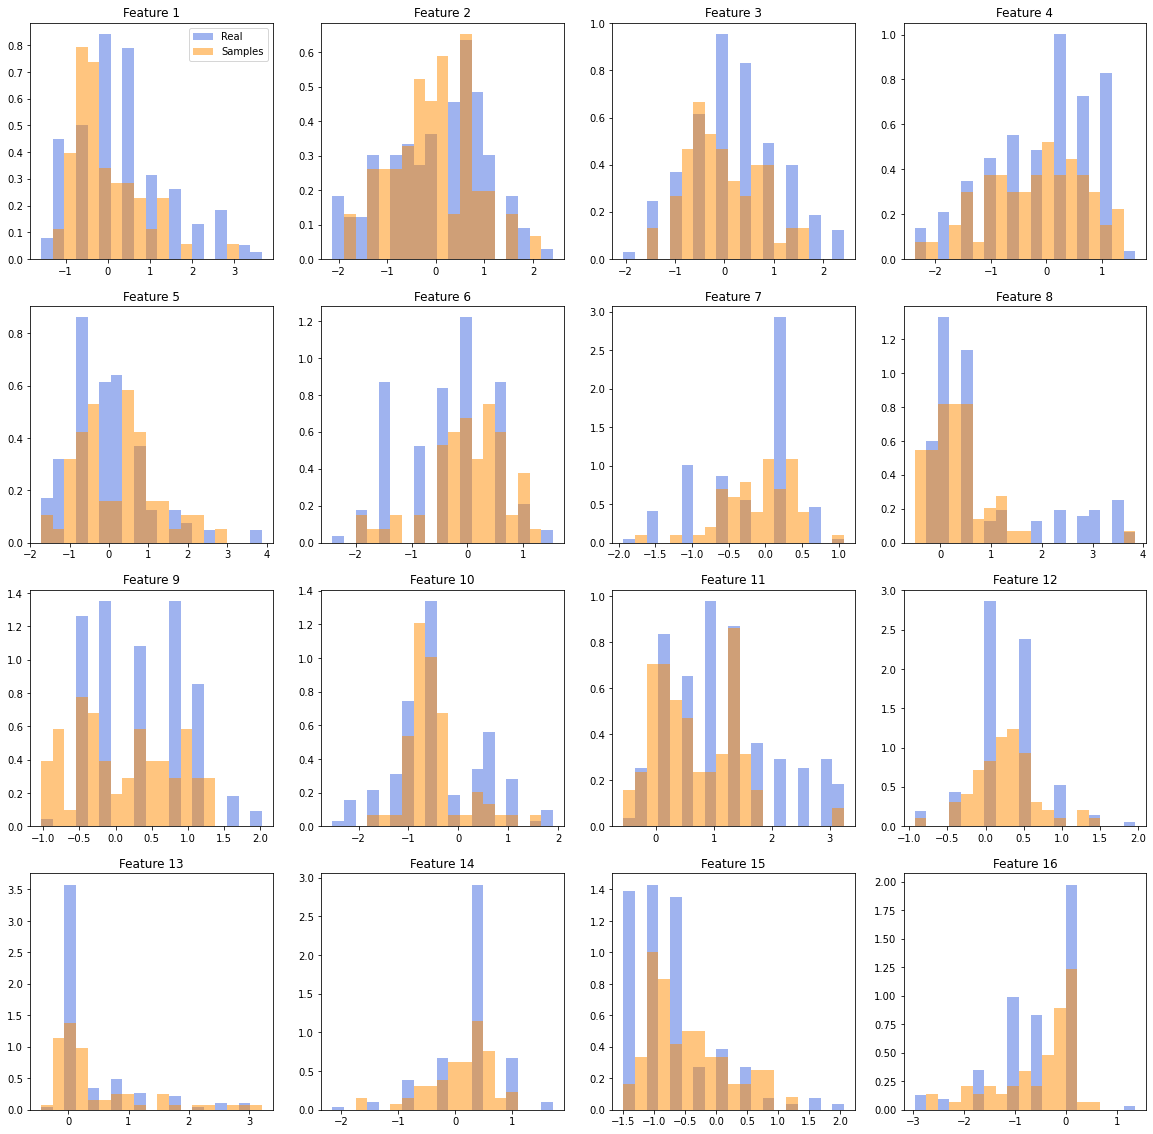

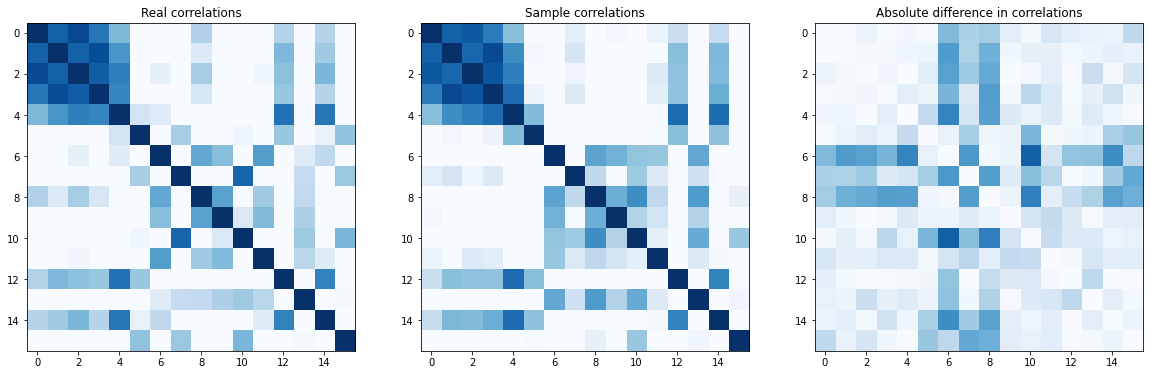

Class V


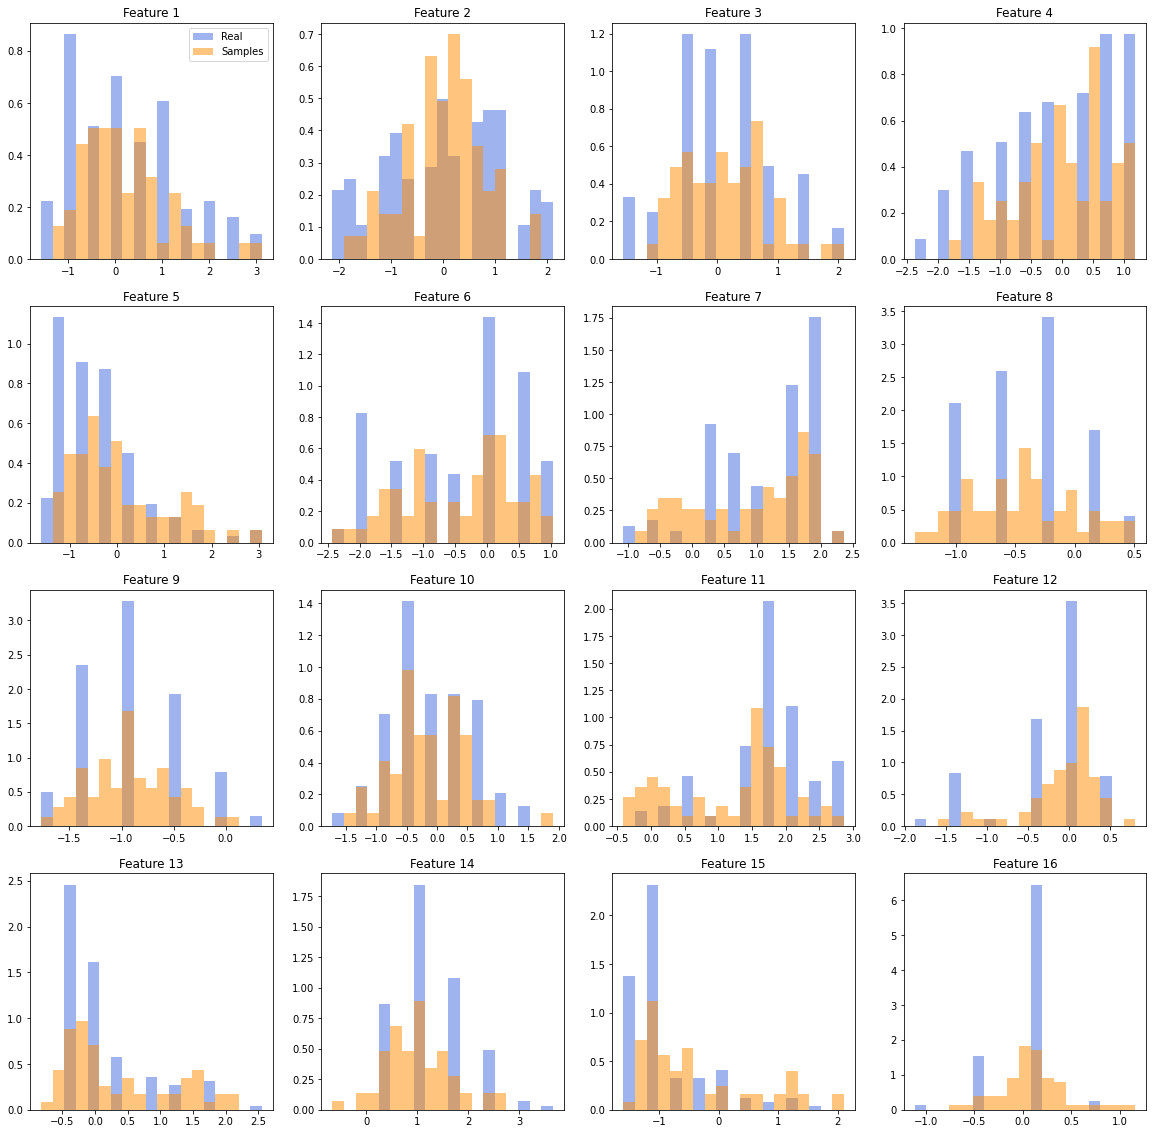

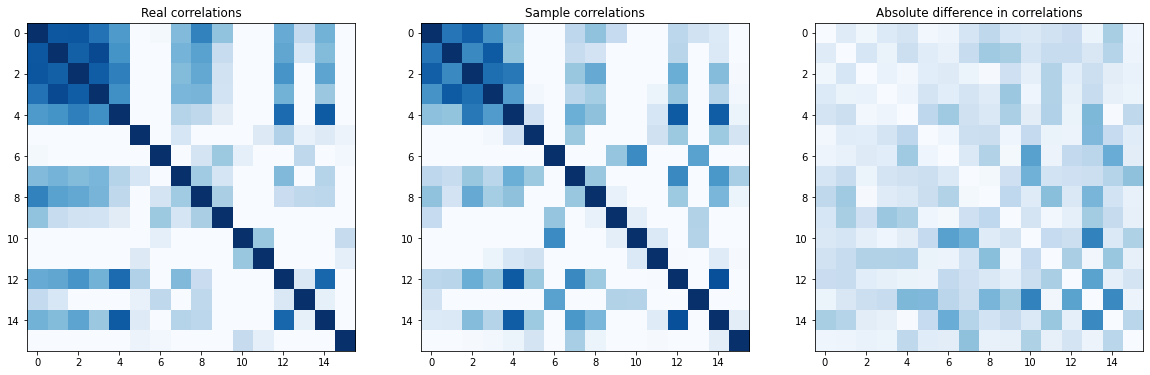

Class W


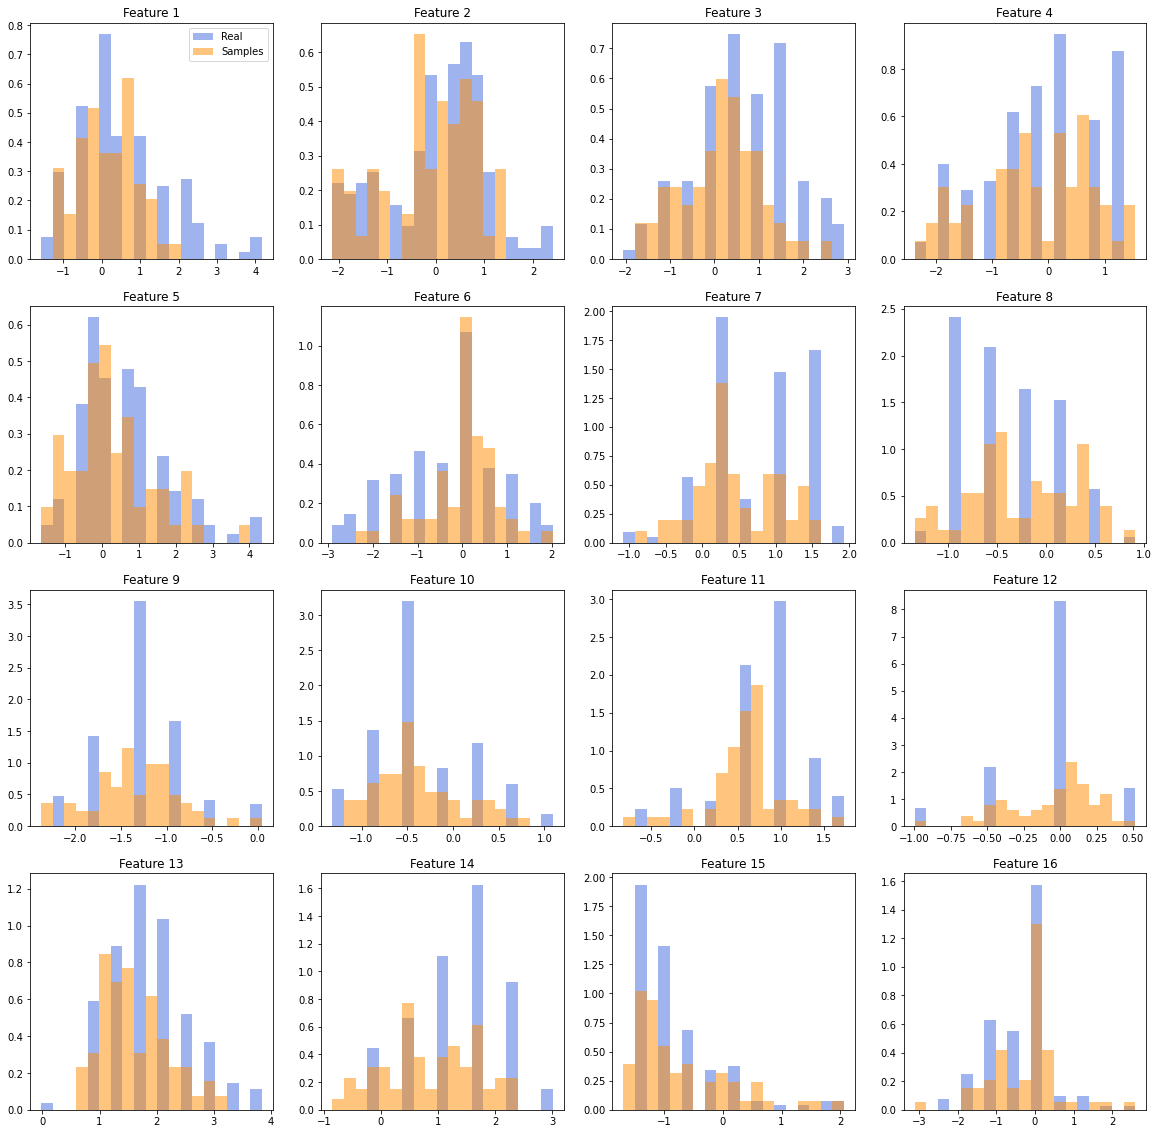

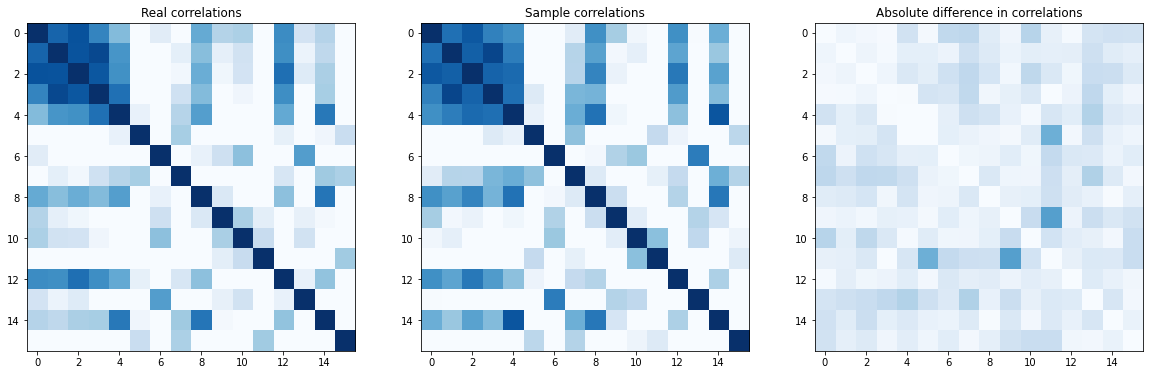

Class X


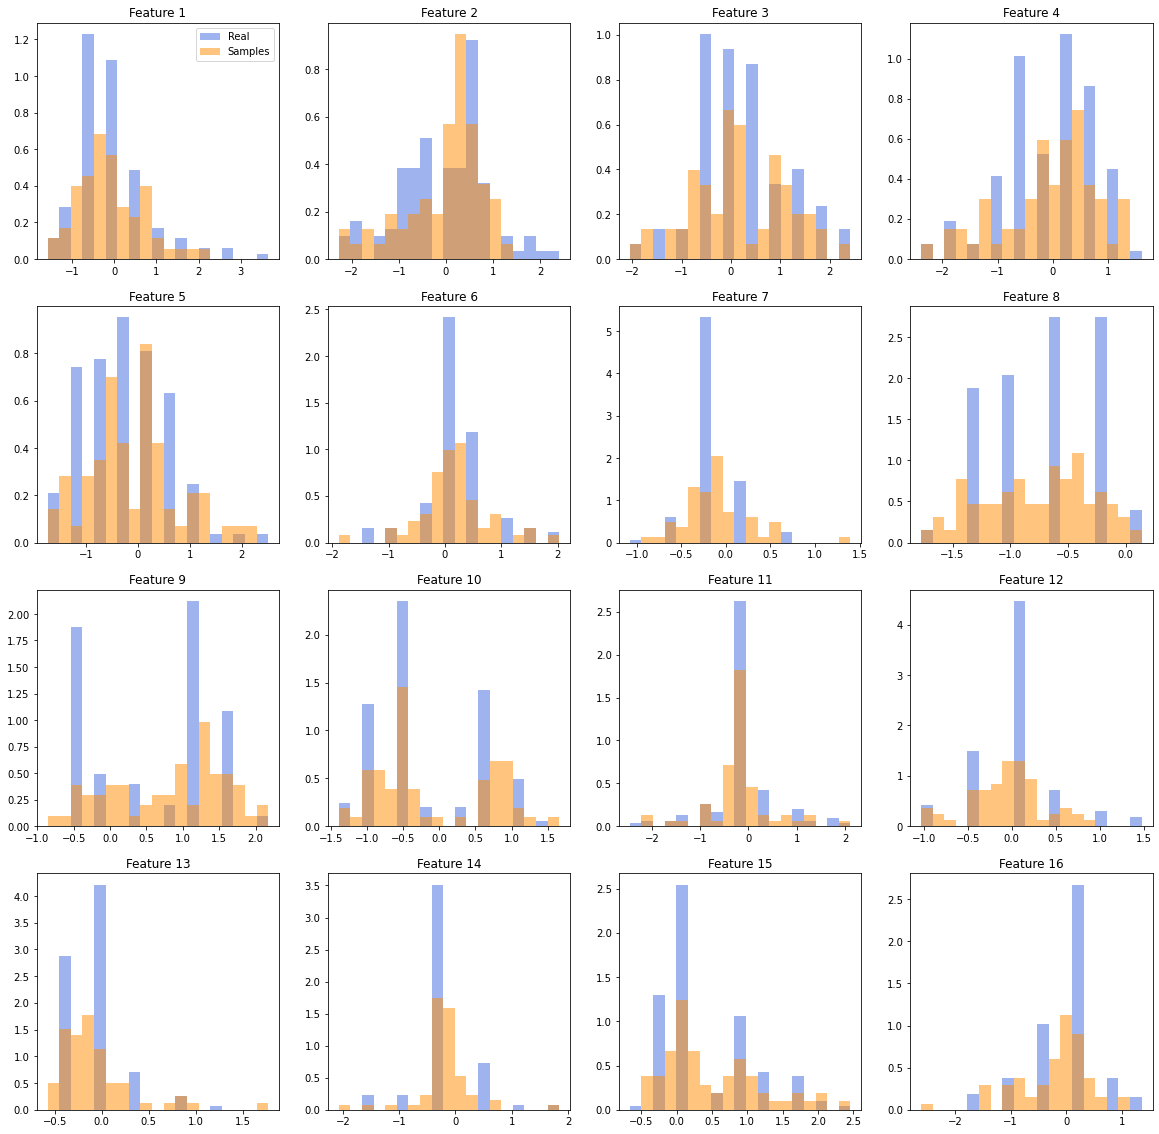

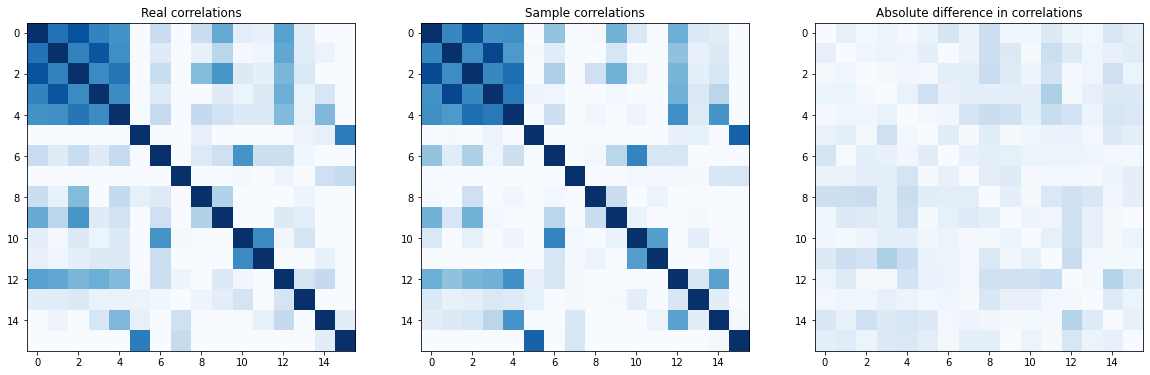

Class Y


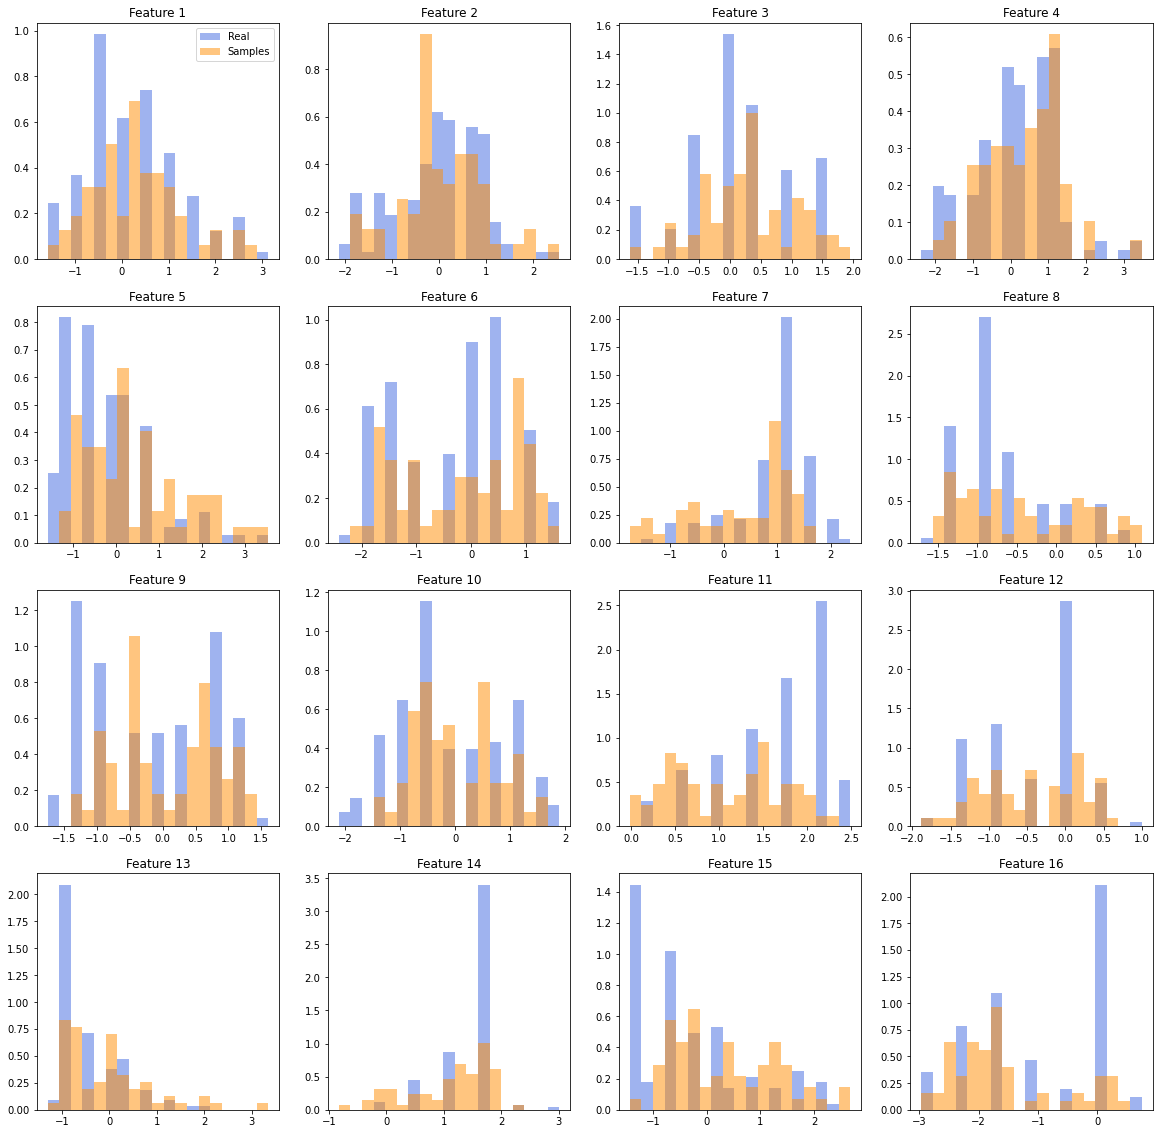

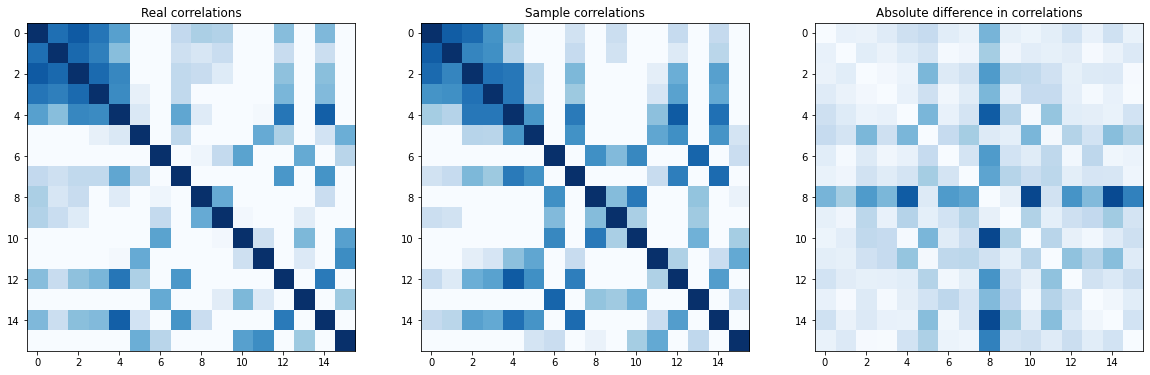

Class Z


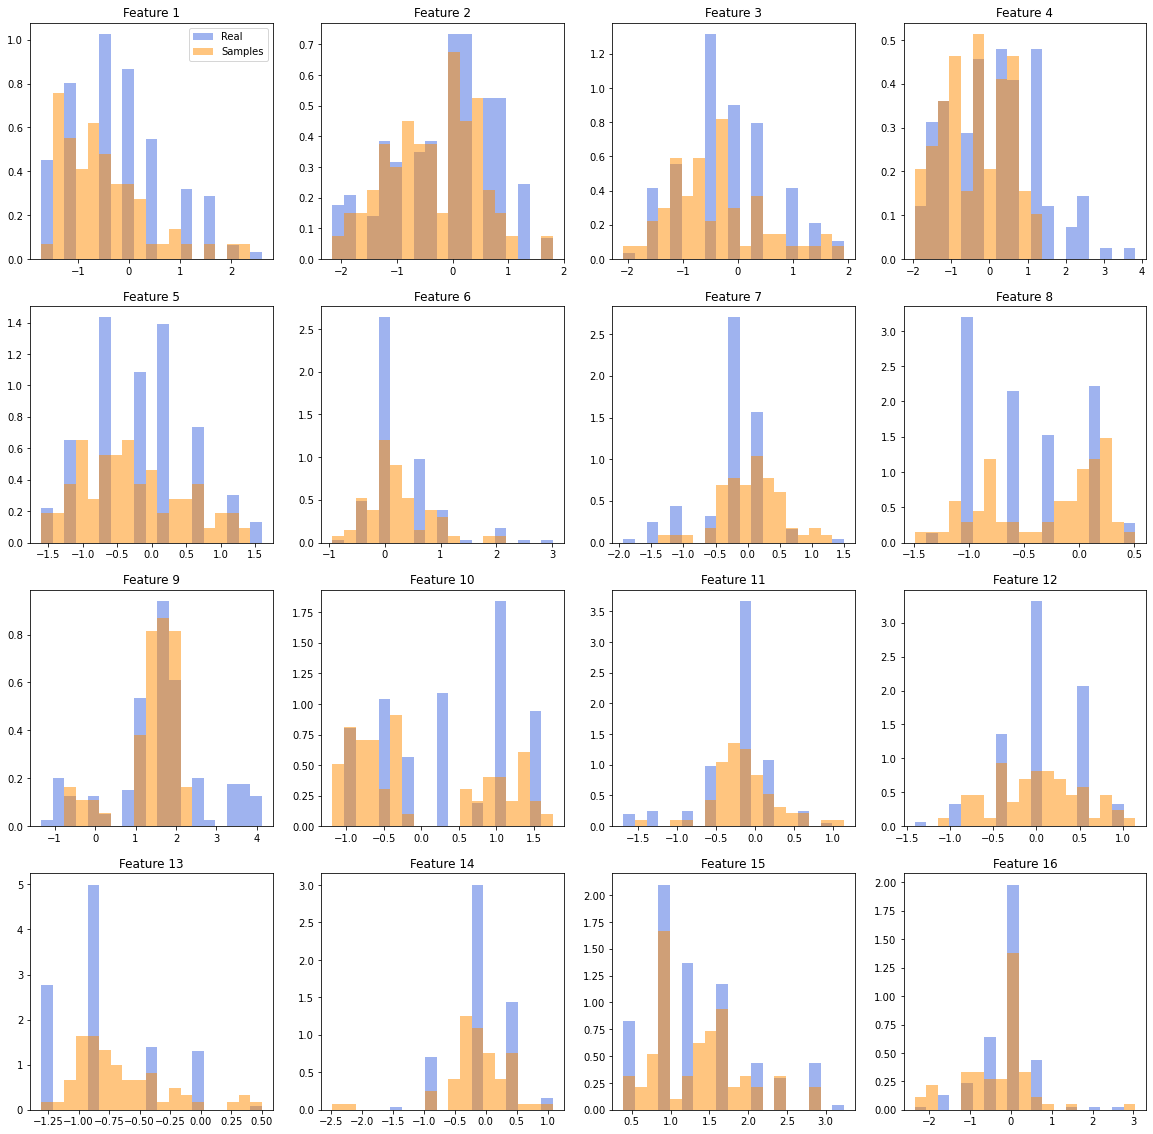

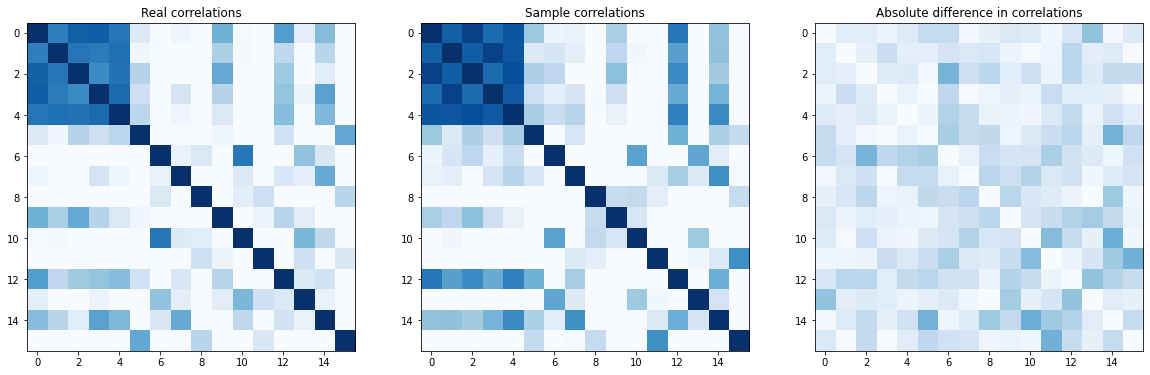

In [10]:
# For simplicity, sample a lot of inputs for the real data
data, targets = [], []
for _ in range(len(classes)):
    x, y = next(iter(data_loader))
    data.append(x.numpy())
    targets.append(y.numpy())
data = np.concatenate([data])
targets = np.concatenate([targets])

for class_to_sample in classes:
    print("Class %s" % class_to_letter[class_to_sample])
    real = data[targets == class_to_sample]
    sample = samples[class_to_sample]
    
    num_features = input_shape[0]
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i in range(num_features):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, i]
        sample_vals = sample[:, i]
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % (i + 1))
    ax[0][0].legend()
    plt.show()

    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i in range(num_features):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, i], real[:, j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, i], sample[:, j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()

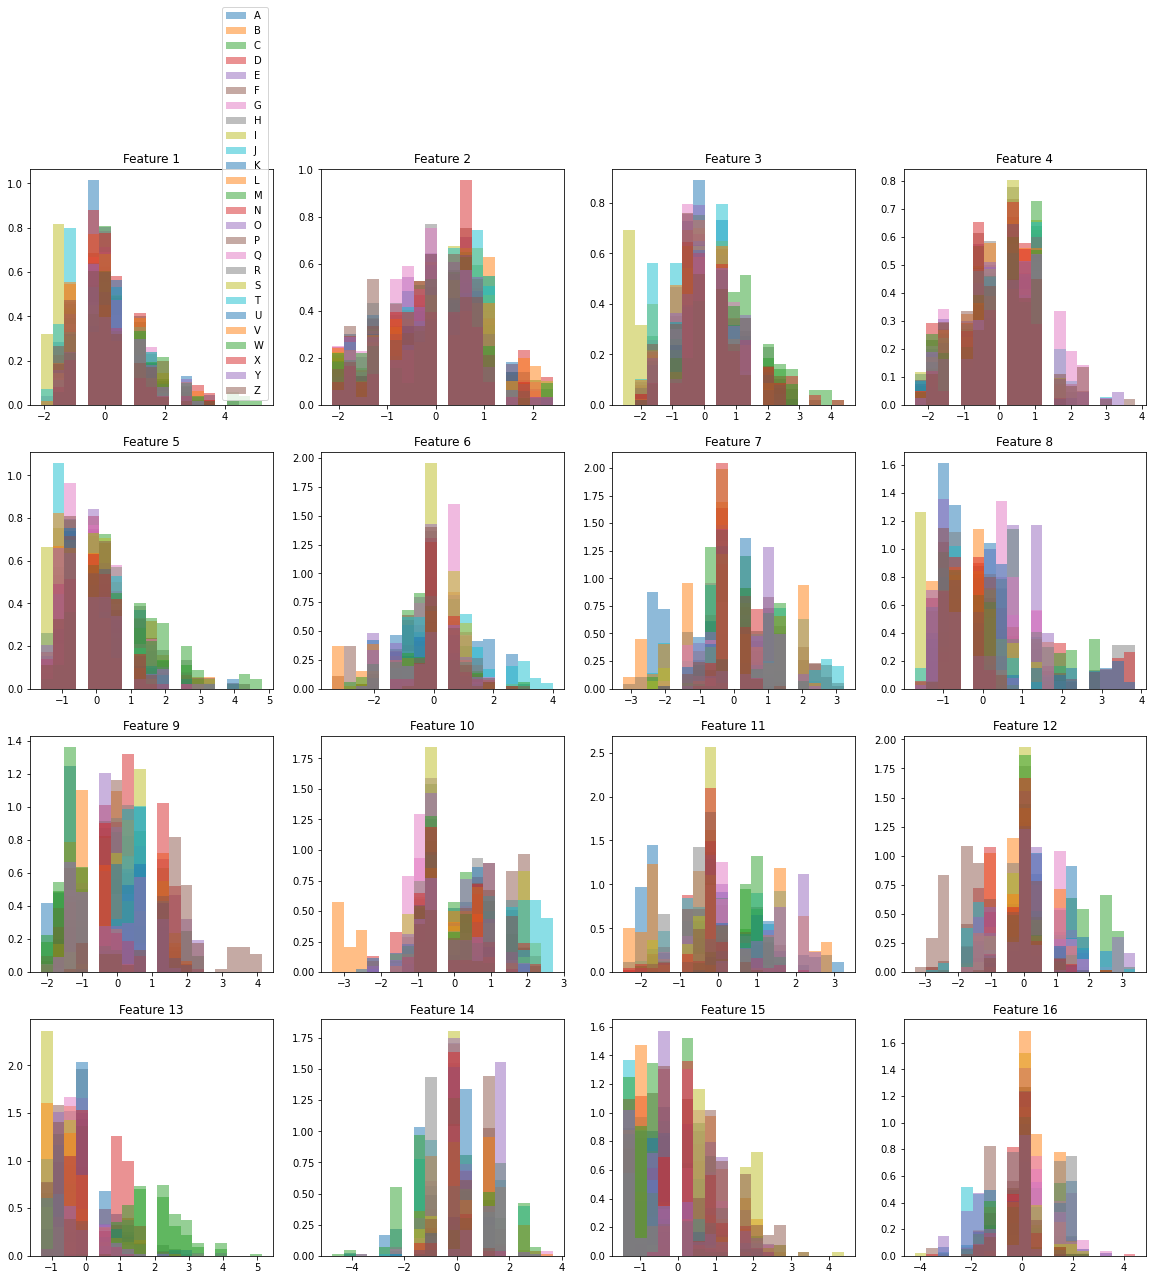

In [11]:
# Plot the distribution of features by class
num_features = input_shape[0]
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))

for i in range(num_features):
    r, c = i // num_cols, i % num_cols
    data_to_plot = {}
    for class_to_sample in classes:
        data_to_plot[class_to_sample] = data[targets == class_to_sample][:, i]
    all_vals = np.concatenate(list(data_to_plot.values()))
    bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
    for class_to_sample in classes:
        ax[r][c].hist(
            data_to_plot[class_to_sample], bins=bins, label=class_to_letter[class_to_sample],
            density=True, alpha=0.5
        )
    ax[r][c].set_title("Feature %d" % (i + 1))
ax[0][0].legend()
plt.show()

**Diffusing from one class to another**

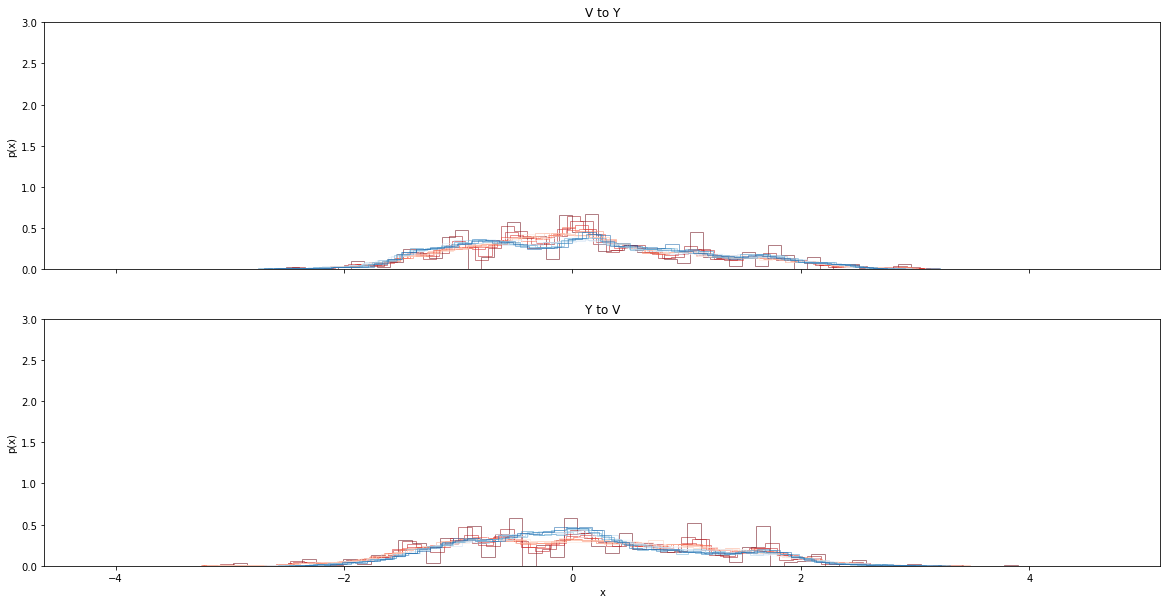

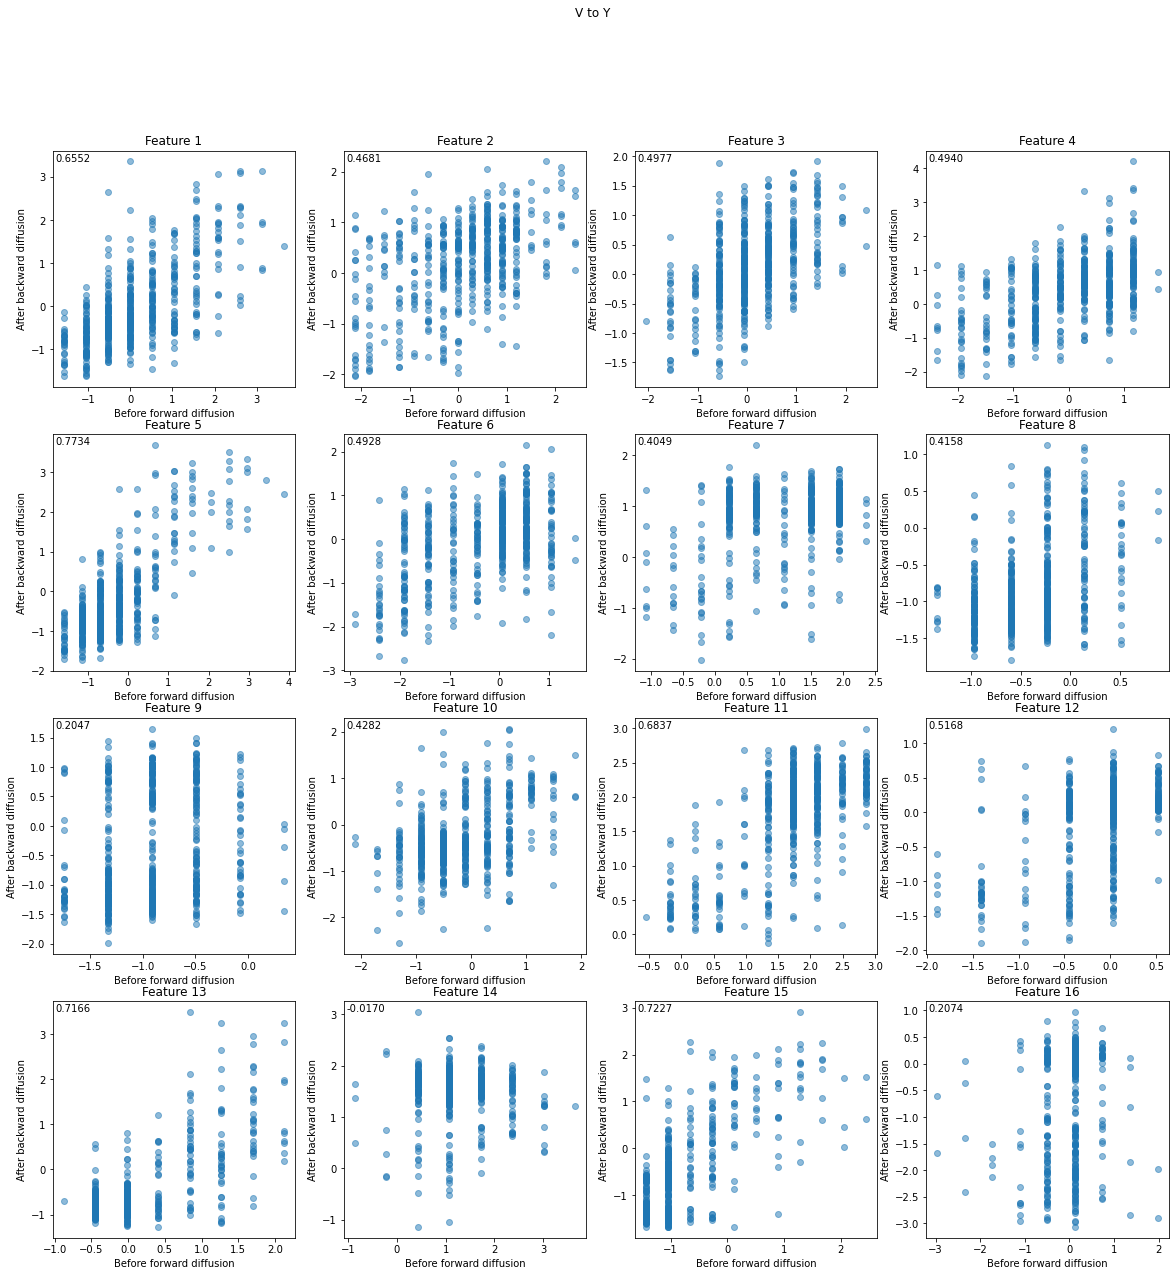

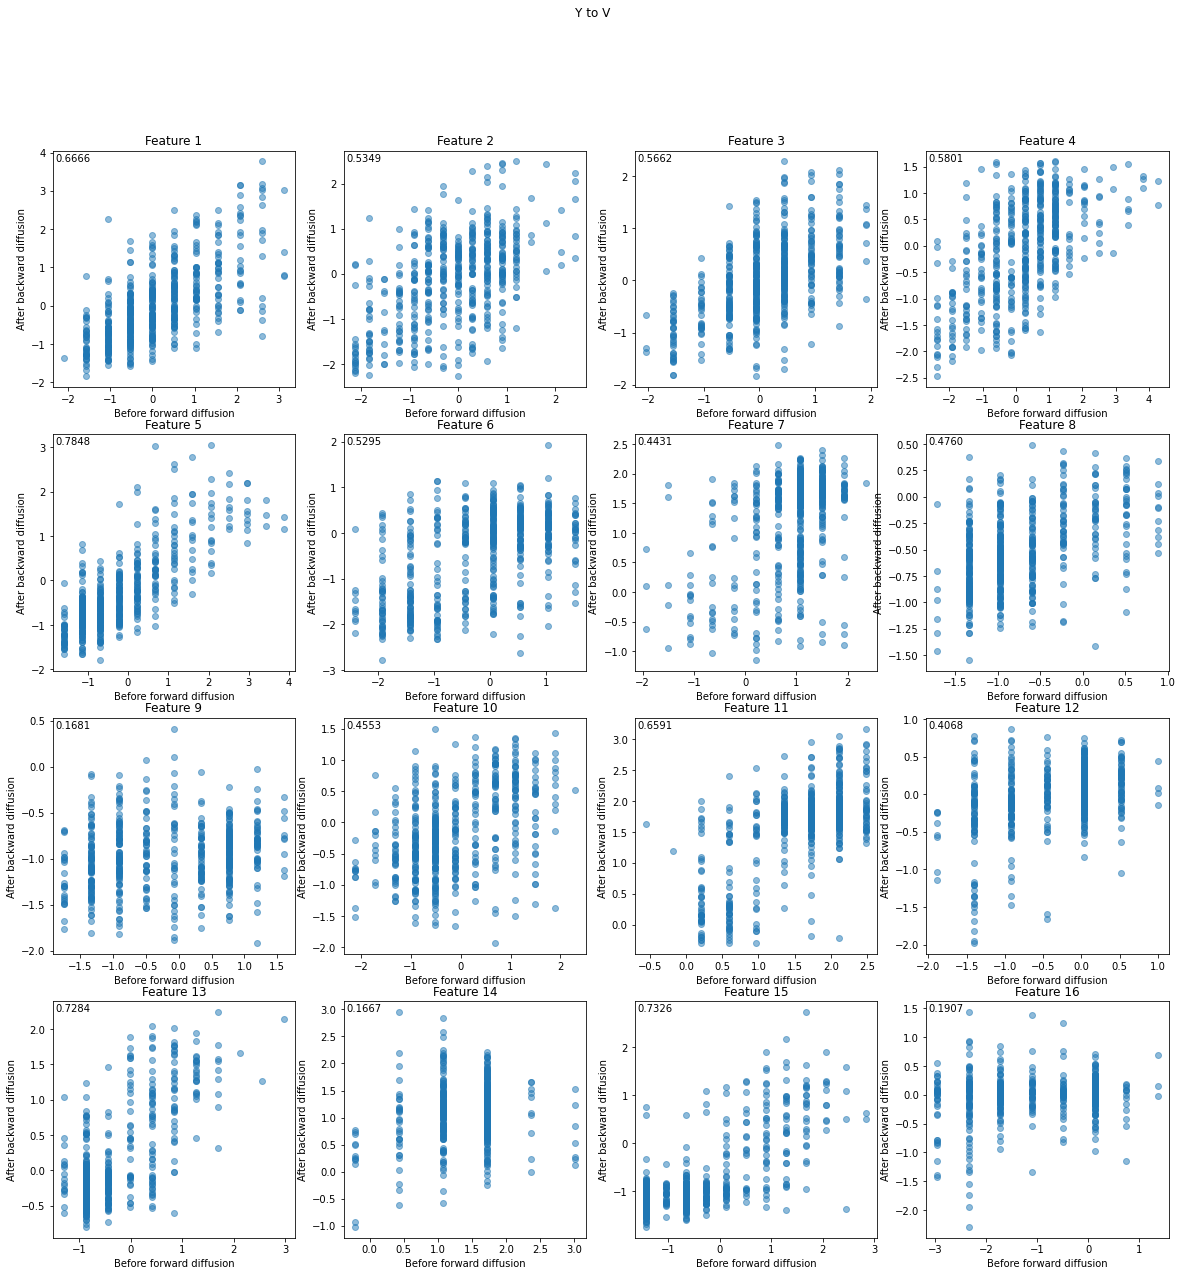

In [12]:
branch_time = 0.35
c1, c2 = "V", "Y"

num_features = input_shape[0]

orig_c1 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == letter_to_class[c1])[0], size=512, replace=False)
])
orig_c2 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == letter_to_class[c2])[0], size=512, replace=False)
])

time_steps = 10
all_t = np.linspace(0, branch_time, time_steps)
forward_c1_to_c2 = np.empty((len(all_t),) + orig_c1.shape)
backward_c1_to_c2 = np.empty((len(all_t) - 1,) + orig_c1.shape)
forward_c2_to_c1 = np.empty((len(all_t),) + orig_c2.shape)
backward_c2_to_c1 = np.empty((len(all_t) - 1,) + orig_c2.shape)
for t_i, t in enumerate(all_t):
    forward_c1_to_c2[t_i] = sde.forward(
        orig_c1, torch.ones(len(orig_c1)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_c2_to_c1[t_i] = sde.forward(
        orig_c2, torch.ones(len(orig_c2)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_c1_to_c2 = torch.tensor(forward_c1_to_c2[-1]).to(DEVICE).float()
last_c2_to_c1 = torch.tensor(forward_c2_to_c1[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_c1_to_c2 = generate.generate_continuous_branched_samples(
        model, sde, letter_to_class[c2], class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_c1.shape[0], initial_samples=last_c1_to_c2,
        num_steps=50
    )
    backward_c1_to_c2[t_i] = last_c1_to_c2.cpu().numpy()
    
    last_c2_to_c1 = generate.generate_continuous_branched_samples(
        model, sde, letter_to_class[c1], class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_c2.shape[0], initial_samples=last_c2_to_c1,
        num_steps=50
    )
    backward_c2_to_c1[t_i] = last_c2_to_c1.cpu().numpy()
    
# Compute correlation of features before and after transmutation
c1_to_c2_corrs, c2_to_c1_corrs = np.empty(num_features), np.empty(num_features)
for i in range(num_features):
    c1_to_c2_corrs[i] = scipy.stats.pearsonr(
        forward_c1_to_c2[0][:, i], backward_c1_to_c2[-1][:, i]
    )[0]
    c2_to_c1_corrs[i] = scipy.stats.pearsonr(
        forward_c2_to_c1[0][:, i], backward_c2_to_c1[-1][:, i]
    )[0]
    
# Plot distribution trajectory in transmutation
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))
forward_cmap = plt.get_cmap("Reds_r")
backward_cmap = plt.get_cmap("Blues")
for t_i in range(len(all_t)):
    ax[0].hist(
        np.ravel(forward_c1_to_c2[t_i]), bins=60, histtype="step", color=forward_cmap(t_i / len(all_t)),
        alpha=0.5, density=True
    )
    ax[1].hist(
        np.ravel(forward_c2_to_c1[t_i]), bins=60, histtype="step", color=forward_cmap(t_i / len(all_t)),
        alpha=0.5, density=True
    )
for t_i, t in enumerate(all_t_flip[1:]):
    ax[0].hist(
        np.ravel(backward_c1_to_c2[t_i]), bins=60, histtype="step", color=backward_cmap(t_i / len(all_t)),
        alpha=0.5, density=True
    )
    ax[1].hist(
        np.ravel(backward_c2_to_c1[t_i]), bins=60, histtype="step", color=backward_cmap(t_i / len(all_t)),
        alpha=0.5, density=True
    )
ax[0].set_title("%s to %s" % (c1, c2))
ax[1].set_title("%s to %s" % (c2, c1))
ax[1].set_xlabel("x")
ax[0].set_ylabel("p(x)")
ax[1].set_ylabel("p(x)")
ax[0].set_ylim((0, 3))
plt.show()

# Plot correlation of features before and after transmutation
num_features = input_shape[0]
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
for class_1, class_2, forwards, backwards in [
    (c1, c2, forward_c1_to_c2[0], backward_c1_to_c2[-1]),
    (c2, c1, forward_c2_to_c1[0], backward_c2_to_c1[-1])
]:
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i in range(num_features):
        r, c = i // num_cols, i % num_cols
        x, y = forwards[:, i], backwards[:, i]
        corr = scipy.stats.pearsonr(x, y)[0]
        ax[r][c].scatter(x, y, alpha=0.5)
        ax[r][c].text(
            0.01, 0.99, "%.4f" % corr,
            ha="left", va="top", transform=ax[r][c].transAxes
        )
        ax[r][c].set_xlabel("Before forward diffusion")
        ax[r][c].set_ylabel("After backward diffusion")
        ax[r][c].set_title("Feature %d" % (i + 1))
    fig.suptitle("%s to %s" % (class_1, class_2))
    plt.show()